# Inequality and Polarization: An Agent-Based Modeling Approach Using Eurostat Data

by:
- Kevin Heinrich, 11902941
- Matthias Hemmer, 11804194
- Marina Hofer, 12337819
- Christina Sophie Knes, 11902902

## Project Description

This project explores the relationship between regional income inequality and social polarization in Europe using agent-based modeling. Drawing on real-world data from Eurostat, including the Gini coefficient, at-risk-of-poverty rates and disposable income across a set of Countries in Europe, we simulate how economic disparities might influence public opinion dynamics and social fragmentation.

We implement a modified Deffuant model, where agents interact and adjust their opinions based on income differences and local economic context. The model integrates heterogeneity in income, frustration levels and opinion tolerance, creating a dynamic system that allows us to observe under which conditions polarization emerges.

Our main objectives are:
- To simulate opinion formation in a socioeconomically stratified population.
- To explore how varying levels of inequality and redistribution affect polarization.
- To identify regional vulnerability to polarization based on Eurostat indicators.

Through these simulations, we aim to provide insights into how economic structures may contribute to societal tensions and how policy interventions might influence collective outcomes.

## Environment Setup

For the following project, **Python Version 3.13.5** was used. The recommended way would be to use a virtual environment when executing the cells in the jupyter notebook. To create a virtual environment, enter the following command:

- `python -m venv .venv`

Afterwards, you can select the python version of the virtual environment for the jupyter kernel.

The following libraries are required for this project:

### Agent-Based Modeling
- **`mesa`** –  A Python framework for building and analyzing agent-based models. Provides components for model structure, agents, data collection, and visualization.

### Data Access and APIs
- **`eurostat`** –  A Python interface to retrieve and process data from the Eurostat database, useful for accessing European statistics.

### Data Manipulation and Analysis
- **`numpy`** –  Fundamental package for numerical computations with support for multi-dimensional arrays and matrices.
- **`numpy.typing`** –  Package for typehints of numpy related datastructures.
- **`pandas`** –  Data manipulation and analysis library providing data structures like Series and DataFrame for handling structured data.

### Data Manipulation and Analysis
- **`matplotlib`** –  2D plotting library used to create static, interactive, and animated visualizations in Python.
- **`seaborn`** –  High-level interface for drawing attractive and informative statistical graphics built on top of matplotlib.

### Standard Library Modules
- **`pathlib`** – Object-oriented interface for working with filesystem paths, included in the Python standard library.


## PIP installations

To install the required libraries, run the following:

In [43]:
! pip install eurostat
! pip install numpy
! pip install pandas
! pip install mesa
! pip install scipy
! pip install matplotlib
! pip install seaborn
! pip install geopandas
! pip install adjustText

## Import modules and define constants

For the structure of this project, we put every import and every constant in one cell each.

In [6]:
import eurostat
from mesa import Model, Agent, DataCollector
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

/home/xanixx/Documents/00_UNI/011_CMSS/project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Simulation and Preprocessing Constants

This section defines the constants used for data filtering and simulation:

**Preprocessing Constants**:
- Define target demographics and units for Eurostat data queries:
  - `TARGET_AGE`, `TARGET_SEX`: Select total population across all ages and sexes.
  - `TARGET_MEAN_INCOME_INDIC`, `TARGET_POVERTY_INDIC`: Indicators for mean income and at-risk-of-poverty.
  - `TARGET_HOUSING_TYPE`, `TARGET_HOUSING_INCOME_GROUP`: Used for filtering housing cost data.
  - `TARGET_UNEMPLOYMENT_AGES`, `TARGET_UNEMPLOYMENT_UNIT`: Define unemployment rate criteria.

**Simulation Constants**:
- `NUM_STEPS`: Number of simulation iterations per run.
- `NUM_AGENTS_PER_REGION`: Number of agents created for each country.
- `SEED`: Random seed for reproducibility.
- `SHIFT_RATE`: Opinion convergence rate in agent interactions.
- `NOISE_STD`: Standard deviation for Gaussian noise added during opinion updates.


In [7]:
# Preprocessing constants
TARGET_AGE = "TOTAL"
TARGET_SEX = "T" # Total
TARGET_MEAN_INCOME_UNIT = "EUR" # Unit of measure for income: Euro
TARGET_MEAN_INCOME_INDIC = "MEI_E" # Income and living conditions indicator: Mean equivalised net income
TARGET_POVERTY_UNIT = "PC"
TARGET_POVERTY_INDIC = "LI_R_M60"
TARGET_HOUSING_INCOME_GROUP = "TOTAL"
TARGET_HOUSING_TYPE = "TOTAL"
TARGET_UNEMPLOYMENT_AGES = "Y15-74"
TARGET_UNEMPLOYMENT_UNIT = "PC_POP"

# Simulation constants
NUM_STEPS = 100
NUM_AGENTS_PER_REGION = 20
SEED = 15
SHIFT_RATE = 0.2
NOISE_STD = 0.05

### Set Seed for "random" calls

The following cell sets the seed for our "random" calls to allow the reproduction of the experiments.

In [8]:
np.random.seed(SEED)

### Define and create "results" directory

The next cell creates the "result" directory (only if it is not created so far) to store our result plots.

In [9]:
result_dir = Path.cwd().joinpath("results")
result_dir.mkdir(parents=True, exist_ok=True)

## 1. Read Eurostat data

### 1.1 Read data from API

Firstly, we download the necessary datasets via the `eurostat` API. In total, we use 5 datasets:

- **Mean and median income by age and sex** (code: ilc_di03)
- **Gini coefficient of equivalised disposable income by age** (code: ilc_di12)
- **At-risk-of-poverty rate by poverty threshold, age and sex** (code: ilc_li02)
- **Share of housing costs in disposable household income, by type of household and income group** (code: ilc_mded01)
- **Unemployment by sex and age - annual data** (code: une_rt_a)

In [10]:
df_orig_mean_median_income = eurostat.get_data_df("ilc_di03")
df_orig_gini_coefficient = eurostat.get_data_df("ilc_di12")
df_orig_at_risk_of_poverty = eurostat.get_data_df("ilc_li02")
df_orig_household_cost_shares = eurostat.get_data_df("ilc_mded01")
df_orig_unemployment_rate = eurostat.get_data_df("une_rt_a")

### 1.2 Fallback: Read data in local data directory

In case of a broken API or connection issues, we provided the possibility to use a local version of the datasets (Date of download: 05.07.2025).

In [333]:
data_path = Path.cwd().joinpath("data")

if df_orig_mean_median_income is None:
    df_orig_mean_median_income = pd.read_csv(data_path.joinpath("mean_and_median_income_ilc_di03.csv"))
    
if df_orig_gini_coefficient is None:
    df_orig_gini_coefficient = pd.read_csv(data_path.joinpath("gini_coefficient_ilc_di12.csv"))
    
if df_orig_at_risk_of_poverty is None:
    df_orig_at_risk_of_poverty = pd.read_csv(data_path.joinpath("at_risk_of_poverty_ilc_li02.csv"))
    
if df_orig_household_cost_shares is None:
    df_orig_household_cost_shares = pd.read_csv(data_path.joinpath("household_cost_shares_ilc_mded01.csv"))
    
if df_orig_unemployment_rate is None:
    df_orig_unemployment_rate = pd.read_csv(data_path.joinpath("unemployment_rate_une_rt_a.csv"))

## 2. Preprocess data

In the following cells, we prepare the preprocessing in terms of defining relevant columns and preprocessing functions. And the subchapters, we preprocess the data such that we keep only relevant years (2014-2024) and such that we have a consistent set of regions (all datasets have to store the same regions) to make simulations as easy as possible.

In [34]:
relevant_years = [str(year) for year in range(2014, 2025)] 
relevant_columns = ["geo"] + relevant_years
non_eu_entities = ['EU27_2020', 'EA20', 'EA18', 'EA19', 'EU27_2007', 'EU28','TR']  

In [35]:
def do_preprocessing_steps(df: pd.DataFrame, filter_options: dict[str, str], convert_percentage: bool) -> pd.DataFrame:
    df = df.rename(columns={"geo\\TIME_PERIOD": "geo"})
    df = df[~df["geo"].isin(non_eu_entities)]
    
    for k, v in filter_options.items():
        df = df[df[k] == v]
    
    df = df[relevant_columns]
    df = df.dropna()
    
    if not convert_percentage:
        return df
    
    for year in relevant_years: 
        df[year] = df[year].div(100).round(4)
        
    return df

### 2.1 Preprocess "Mean and Median income" Dataset

In [13]:
filter_options = {"sex": TARGET_SEX, "age": TARGET_AGE, "unit": TARGET_MEAN_INCOME_UNIT, "indic_il": TARGET_MEAN_INCOME_INDIC}

df_processed_mean_median_income = df_orig_mean_median_income.copy(deep=True)
df_processed_mean_median_income = do_preprocessing_steps(df_processed_mean_median_income, filter_options, False)

### 2.2 Preprocess "Gini Coefficient" Dataset

In [14]:
filter_options = {"age": TARGET_AGE}

df_processed_gini_coefficient = df_orig_gini_coefficient.copy(deep=True)
df_processed_gini_coefficient = do_preprocessing_steps(df_processed_gini_coefficient, filter_options, True)

### 2.3 Preprocess "At-risk-of-poverty" Dataset

In [15]:
filter_options = {"sex": TARGET_SEX, "age": TARGET_AGE, "unit": TARGET_POVERTY_UNIT, "indic_il": TARGET_POVERTY_INDIC}

df_processed_at_risk_of_poverty = df_orig_at_risk_of_poverty.copy(deep=True)
df_processed_at_risk_of_poverty = do_preprocessing_steps(df_processed_at_risk_of_poverty, filter_options, True)

### 2.4 Preprocess "Housing Cost" Dataset

In [16]:
filter_options = {"incgrp": TARGET_HOUSING_INCOME_GROUP, "hhtyp": TARGET_HOUSING_TYPE}

df_processed_household_cost_shares = df_orig_household_cost_shares.copy(deep=True)
df_processed_household_cost_shares = do_preprocessing_steps(df_processed_household_cost_shares, filter_options, True)

### 2.5 Preprocess "Unemployment" Dataset

In [17]:
filter_options = {"age": TARGET_UNEMPLOYMENT_AGES, "sex": TARGET_SEX, "unit": TARGET_UNEMPLOYMENT_UNIT}

df_processed_unemployment_rate = df_orig_unemployment_rate.copy(deep=True)
df_processed_unemployment_rate = do_preprocessing_steps(df_processed_unemployment_rate, filter_options, True)

### 2.6 Calculate intersection of regions between all datasets


In [19]:
distinct_regions_mean_median_income = set(df_processed_mean_median_income["geo"].unique())
distinct_regions_gini_coefficient = set(df_processed_gini_coefficient["geo"].unique())
distinct_regions_risk_of_poverty = set(df_processed_at_risk_of_poverty["geo"].unique())
distinct_regions_household_cost_shares = set(df_processed_household_cost_shares["geo"].unique())
distinct_regions_unemployment_rate = set(df_processed_unemployment_rate["geo"].unique())

shared_regions = distinct_regions_mean_median_income & distinct_regions_gini_coefficient & distinct_regions_household_cost_shares & distinct_regions_risk_of_poverty & distinct_regions_unemployment_rate

df_processed_mean_median_income = df_processed_mean_median_income[df_processed_mean_median_income["geo"].isin(shared_regions)].copy()
df_processed_gini_coefficient = df_processed_gini_coefficient[df_processed_gini_coefficient["geo"].isin(shared_regions)].copy()
df_processed_at_risk_of_poverty = df_processed_at_risk_of_poverty[df_processed_at_risk_of_poverty["geo"].isin(shared_regions)].copy()
df_processed_household_cost_shares = df_processed_household_cost_shares[df_processed_household_cost_shares["geo"].isin(shared_regions)].copy()
df_processed_unemployment_rate = df_processed_unemployment_rate[df_processed_unemployment_rate["geo"].isin(shared_regions)].copy()

## 3. Define Dataframe merge method

For simplicity, we define a merging function to combine multiple dataframes at ones. The all have to share one common key.

In [20]:
def merge_dataframes(dfs: list[pd.DataFrame], key: str) -> pd.DataFrame:
    if len(dfs) == 0:
        return pd.DataFrame()
    
    result_df = dfs[0]
    for df in dfs[1:]:
        result_df = result_df.merge(df, left_on=key, right_on=key)
        
    return result_df

## 4. Generate Synthetic Income Distribution

With help of the average income and gini coefficient of each region, we calculate synthetic incomes via the log-normal distribution.

In [21]:
# See: https://en.wikipedia.org/wiki/Log-normal_distribution
def generate_synthetic_income_distribution(avg_income: float, gini: float, n: int = NUM_AGENTS_PER_REGION) -> NDArray[np.float64]:
    sigma = gini * 1.5  # empirical tuning -> add more variance 
    mu = np.log(avg_income) - (sigma ** 2) / 2
    return np.random.lognormal(mean=mu, sigma=sigma, size=n)

This block generates synthetic income distributions for each country and year based on Eurostat data.

For each year:
- Regional mean income and Gini coefficients are merged.
- The `generate_synthetic_income_distribution` function uses these values to create a realistic income distribution per region.
- Results are stored in the `income_distributions` dictionary, organized by year and region.

These synthetic incomes are later assigned to agents during model initialization to reflect real-world income variability across countries.

In [22]:
income_distributions = {}

for year in relevant_years:
    mean_incomes = df_processed_mean_median_income[["geo", year]].rename(columns={year: "mean"})
    gini_coefficients = df_processed_gini_coefficient[["geo", year]].rename(columns={year: "gini"})
    df_merged = merge_dataframes([mean_incomes, gini_coefficients], key="geo")
    
    distributions_by_year = {}
    for _, row in df_merged.iterrows():
        region = row["geo"]
        mean_income = row["mean"]
        gini = row["gini"]
        distributions_by_year[region] = generate_synthetic_income_distribution(mean_income, gini)
    
    income_distributions[year] = distributions_by_year

## 5. Create the ABM

### 5.1 PersonAgent

Each `PersonAgent` represents an individual in the simulation with attributes based on regional socioeconomic data:

- **Income & Region**: Used to compute whether the agent is in poverty (income < 60% of regional average).
- **Effective Income**: Adjusted for housing costs if provided.
- **Frustration**: Increases if income is below average, if unemployed, or if in poverty; bounded between 0 and 1.
- **Tolerance**: Inversely related to frustration; more frustrated agents are less open to others' opinions.

During each step, agents interact randomly. If their opinion difference is below both agents' tolerance thresholds, they update their opinions using a convergence formula with added Gaussian noise. This reflects the idea that economic dissatisfaction reduces willingness to compromise.


In [345]:
class PersonAgent(Agent):
    def __init__(self,
                model: Model,
                region: str,
                income: float,
                gini: float,
                opinion: float,
                household_cost_share: float | None,
                unemployment_rate: float,
                ) -> None:
        super().__init__(model)
        self.region = region
        region_avg = self.model.region_data[self.model.region_data["geo"] == region]["mean"].values[0]
        self.income = income
        self.gini = gini
        self.opinion = opinion
        self.effective_income = income
        if household_cost_share is not None:
            self.effective_income = income * (1 - household_cost_share)
        self.poverty_flag = True if self.income < region_avg * 0.6 else False
        self.unemployment_rate = unemployment_rate
        
        self.compute_frustration(region_avg)
        
        # Tolerance: more frustration → less tolerance
        self.tolerance = max(0.01, 0.5 * (1 - self.frustration))
        
    def compute_frustration(self, region_avg: float) -> None:
        # Frustration increases if income is below region average or in poverty
        self.frustration = float(max(0, (region_avg - self.effective_income) / region_avg))
        self.frustration = float(min(1, self.frustration + self.unemployment_rate  * 0.5))
        if self.poverty_flag:
            self.frustration = float(min(1, self.frustration + 0.25))  # amplify if in poverty

    def step(self) -> None:
        partner: PersonAgent = self.random.choice(self.model.agents)
        delta = abs(self.opinion - partner.opinion)
        
        noise1 = self.random.gauss(0, NOISE_STD)
        noise2 = self.random.gauss(0, NOISE_STD)
        
        if delta < self.tolerance and delta < partner.tolerance:
            mu = self.model.mu
            opinion1, opinion2 = self.opinion, partner.opinion
            self.opinion += mu * (opinion2 - opinion1) * (1-self.frustration) + noise1
            partner.opinion += mu * (opinion1 - opinion2) * (1-partner.frustration) + noise2
            # Ensure to stay in a valid range
            self.opinion = min(max(self.opinion, 0), 1)
            partner.opinion = min(max(partner.opinion, 0), 1)

### 5.2 InequalityModel

The `InequalityModel` initializes agents based on real regional data and synthetic income distributions. Each country (region) receives a set number of agents with income, unemployment and housing cost attributes.

Key features:
- **Agent Initialization**: For each region, agents are created with sampled income and assigned attributes from `region_data`.
- **Model Parameters**: Includes a convergence rate `mu` and random seed for reproducibility.
- **Data Collection**: Tracks metrics such as opinion variance, frustration, and poverty—both overall and by region—using Mesa's `DataCollector`.

The simulation is run over a fixed number of steps, after which model- and agent-level data are returned for analysis.


In [346]:
class InequalityModel(Model):
    def __init__(self, region_data: pd.DataFrame, synthetic_incomes: dict[str, list[float]], agents_per_region: int, mu: float):
        super().__init__(seed=SEED)
        self.mu = mu
        self.region_data = region_data

        self.init_agents(synthetic_incomes, agents_per_region)

        self.datacollector = DataCollector(
            model_reporters={
                "OpinionVariance": lambda m: np.var([a.opinion for a in m._agents]).round(4),
                "OpinionSTD": lambda m: np.std([a.opinion for a in m._agents]).round(4),
                "OpinionSTDByRegion": lambda m: {
                                                    region: np.std([a.opinion for a in m._agents if a.region == region])
                                                    for region in set(a.region for a in m._agents)
                                                },
                "OpinionMean": lambda m: np.mean([a.opinion for a in m._agents]).round(4),
                "OpinionMeanByRegion": lambda m: {
                                                    region: np.mean([a.opinion for a in m._agents if a.region == region])
                                                    for region in set(a.region for a in m._agents)
                                                },
                "FrustrationVariance": lambda m: np.var([a.frustration for a in m._agents]).round(4),
                "FrustrationMean": lambda m: np.mean([a.frustration for a in m._agents]).round(4),
                "FrustrationMeanByRegion": lambda m: {
                                                    region: np.mean([a.frustration for a in m._agents if a.region == region])
                                                    for region in set(a.region for a in m._agents)
                                                },
                "poverty_mean": lambda m: np.mean([a.poverty_flag for a in m._agents]),
                "PovertyMeanByRegion": lambda m: {
                                                    region: np.mean([a.poverty_flag for a in m._agents if a.region == region])
                                                    for region in set(a.region for a in m._agents)
                                                }
            },
            agent_reporters={
                "Opinion": "opinion",
                "Region": "region",
                "Frustration": "frustration"
            }
        )


    def init_agents(self, synthetic_incomes: dict[str, list[float]], agents_per_region: int):
        for _, row in self.region_data.iterrows():
            region = row['geo']
            gini = row['gini']
            household_cost_share = row["household_cost_share"] if "household_cost_share" in row.index else None
            unemployment_rate = row["unemployment_rate"]

            for i in range(agents_per_region):
                income = synthetic_incomes[region][i]
                opinion = np.random.uniform(0, 1)
                
                PersonAgent(self, region, income, gini, opinion, household_cost_share, unemployment_rate)
                
    def reset_frustration(self):
        for agent in self.agents:
            agent.frustration = 0

    def run_simulation(self, number_of_steps: int) -> tuple[pd.DataFrame, pd.DataFrame]:
        for _ in range(number_of_steps):
            self.agents.do("step")
        self.datacollector.collect(self)
        model_df = self.datacollector.get_model_vars_dataframe()
        agent_df = self.datacollector.get_agent_vars_dataframe()
        
        return model_df, agent_df

## 6. Run simulations

### 6.1 Run model with all factors

In [347]:
mean_frustrations_over_years_all_factors = {}
mean_frustrations_dict_over_years_all_factors = {}
mean_opinions_over_years_all_factors = {}
mean_opinions_dict_over_years_all_factors = {}
std_opinions_over_years_all_factors = {}
std_opinions_dict_over_years_all_factors = {}
poverty_dict_all_factors = {}
poverty_mean_all_factors = {}

for year in relevant_years:
    mean_incomes = df_processed_mean_median_income[["geo", year]].rename(columns={year: "mean"})
    gini_coefficients = df_processed_gini_coefficient[["geo", year]].rename(columns={year: "gini"})
    household_costs = df_processed_household_cost_shares[["geo", year]].rename(columns={year: "household_cost_share"})
    unemployment_rate = df_processed_unemployment_rate[["geo", year]].rename(columns={year: "unemployment_rate"})
    df_region_data = merge_dataframes([mean_incomes, gini_coefficients, household_costs, unemployment_rate], key="geo")

    model = InequalityModel(region_data=df_region_data, synthetic_incomes=income_distributions[year], agents_per_region=NUM_AGENTS_PER_REGION, mu=SHIFT_RATE)
    model_df_sim_1, agent_df_sim_1 = model.run_simulation(NUM_STEPS)
    
    mean_frustrations_over_years_all_factors[year] = model_df_sim_1["FrustrationMean"].values[0]
    mean_frustrations_dict_over_years_all_factors[year] = model_df_sim_1["FrustrationMeanByRegion"]
    mean_opinions_over_years_all_factors[year] = model_df_sim_1["OpinionMean"].values[0]
    mean_opinions_dict_over_years_all_factors[year] = model_df_sim_1["OpinionMeanByRegion"]
    std_opinions_over_years_all_factors[year] = model_df_sim_1["OpinionSTD"].values[0]
    std_opinions_dict_over_years_all_factors[year] = model_df_sim_1["OpinionSTDByRegion"]
    poverty_mean_all_factors[year] = model_df_sim_1["poverty_mean"].values[0]
    poverty_dict_all_factors[year] = model_df_sim_1["PovertyMeanByRegion"]

### 6.2 Run model and exclude only household share costs

In [348]:
mean_frustrations_over_years_exclude_household_share = {}
mean_frustrations_dict_over_years_exclude_household_share = {}
mean_opinions_over_years_exclude_household_share = {}
mean_opinions_dict_over_years_exclude_household_share = {}
std_opinions_over_years_exclude_household_share = {}
std_opinions_dict_over_years_exclude_household_share = {}
poverty_dict_exclude_household_share = {}
poverty_mean_exclude_household_share = {}

for year in relevant_years:
    mean_incomes = df_processed_mean_median_income[["geo", year]].rename(columns={year: "mean"})
    gini_coefficients = df_processed_gini_coefficient[["geo", year]].rename(columns={year: "gini"})
    unemployment_rate = df_processed_unemployment_rate[["geo", year]].rename(columns={year: "unemployment_rate"})
    df_region_data = merge_dataframes([mean_incomes, gini_coefficients, unemployment_rate], key="geo")

    model = InequalityModel(region_data=df_region_data, synthetic_incomes=income_distributions[year], agents_per_region=NUM_AGENTS_PER_REGION, mu=SHIFT_RATE)
    model_df_sim_2, agent_df_sim_2 = model.run_simulation(NUM_STEPS)
    
    mean_frustrations_over_years_exclude_household_share[year] = model_df_sim_2["FrustrationMean"].values[0]
    mean_frustrations_dict_over_years_exclude_household_share[year] = model_df_sim_2["FrustrationMeanByRegion"]
    mean_opinions_over_years_exclude_household_share[year] = model_df_sim_2["OpinionMean"].values[0]
    mean_opinions_dict_over_years_exclude_household_share[year] = model_df_sim_2["OpinionMeanByRegion"]
    std_opinions_over_years_exclude_household_share[year] = model_df_sim_2["OpinionSTD"].values[0]
    std_opinions_dict_over_years_exclude_household_share[year] = model_df_sim_2["OpinionSTDByRegion"]
    poverty_mean_exclude_household_share[year] = model_df_sim_2["poverty_mean"].values[0]
    poverty_dict_exclude_household_share[year] = model_df_sim_2["PovertyMeanByRegion"]

### 6.3 Run baseline model

In [349]:
mean_opinions_over_years_no_frustration = {}
mean_opinions_dict_over_years_no_frustration = {}
std_opinions_over_years_no_frustration = {}
std_opinions_dict_over_years_no_frustration = {}

for year in relevant_years:
    mean_incomes = df_processed_mean_median_income[["geo", year]].rename(columns={year: "mean"})
    gini_coefficients = df_processed_gini_coefficient[["geo", year]].rename(columns={year: "gini"})
    unemployment_rate = df_processed_unemployment_rate[["geo", year]].rename(columns={year: "unemployment_rate"})
    df_region_data = merge_dataframes([mean_incomes, gini_coefficients, unemployment_rate], key="geo")

    model = InequalityModel(region_data=df_region_data, synthetic_incomes=income_distributions[year], agents_per_region=NUM_AGENTS_PER_REGION, mu=SHIFT_RATE)
    model.reset_frustration()
    model_df_sim_3, agent_df_sim_3 = model.run_simulation(NUM_STEPS)

    mean_opinions_over_years_no_frustration[year] = model_df_sim_3["OpinionMean"].values[0]
    mean_opinions_dict_over_years_no_frustration[year] = model_df_sim_3["OpinionMeanByRegion"]
    std_opinions_over_years_no_frustration[year] = model_df_sim_3["OpinionSTD"].values[0]
    std_opinions_dict_over_years_no_frustration[year] = model_df_sim_3["OpinionSTDByRegion"]

## 7. Visualisation and Analysis

### 7.1 Frustration With vs. Without Housing Cost Adjustment

This side-by-side bar chart compares the simulated average frustration across years under two conditions:

- **With household cost share**: Agents' effective income is reduced by housing costs.
- **Without household cost share**: Housing costs are ignored in frustration computation.

- Each year shows two bars for direct comparison.
- This visualization highlights the impact of housing expenses on modeled economic frustration levels.

The chart illustrates how incorporating housing costs can elevate frustration levels, especially in economically strained years.


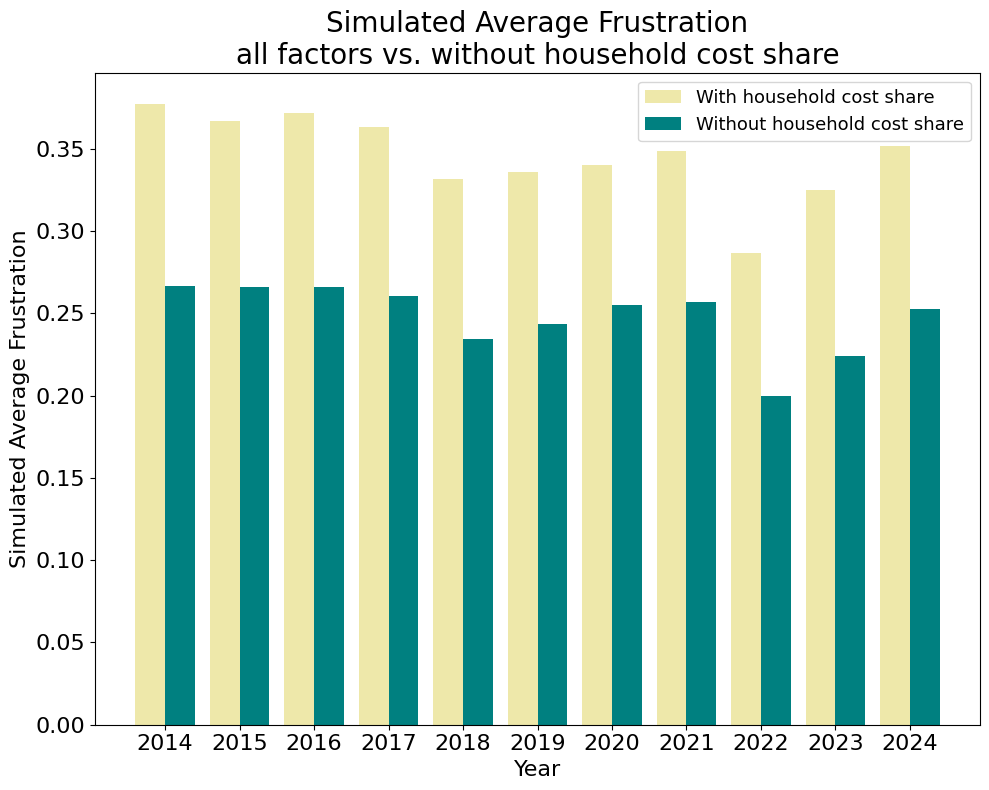

In [385]:
x = np.arange(len(relevant_years))  # numeric positions for shared years
bar_width = 0.4

# Plot bars
plt.figure(figsize=(10, 8))
plt.bar(x - bar_width/2, list(mean_frustrations_over_years_all_factors.values()), width=bar_width, label='With household cost share', color='palegoldenrod')
plt.bar(x + bar_width/2, list(mean_frustrations_over_years_exclude_household_share.values()), width=bar_width, label='Without household cost share', color='teal')

# Axis labels and ticks
plt.xticks(x, relevant_years)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Simulated Average Frustration", fontsize=16)
plt.title("Simulated Average Frustration\nall factors vs. without household cost share", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.legend(fontsize=13)
plt.tight_layout()
plt.savefig(result_dir.joinpath("average_frustration_with_and_without_household_cost_share.pdf"), format="pdf")
plt.show()

### 7.2 Average Frustration Over Time

This plot shows the simulated average frustration levels across all countries for each year in the dataset.

- Each bar represents one year for clarity.
- Frustration is a model-derived metric influenced by income, poverty and unemployment.
- The chart provides a high-level view of how economic dissatisfaction varies over time.

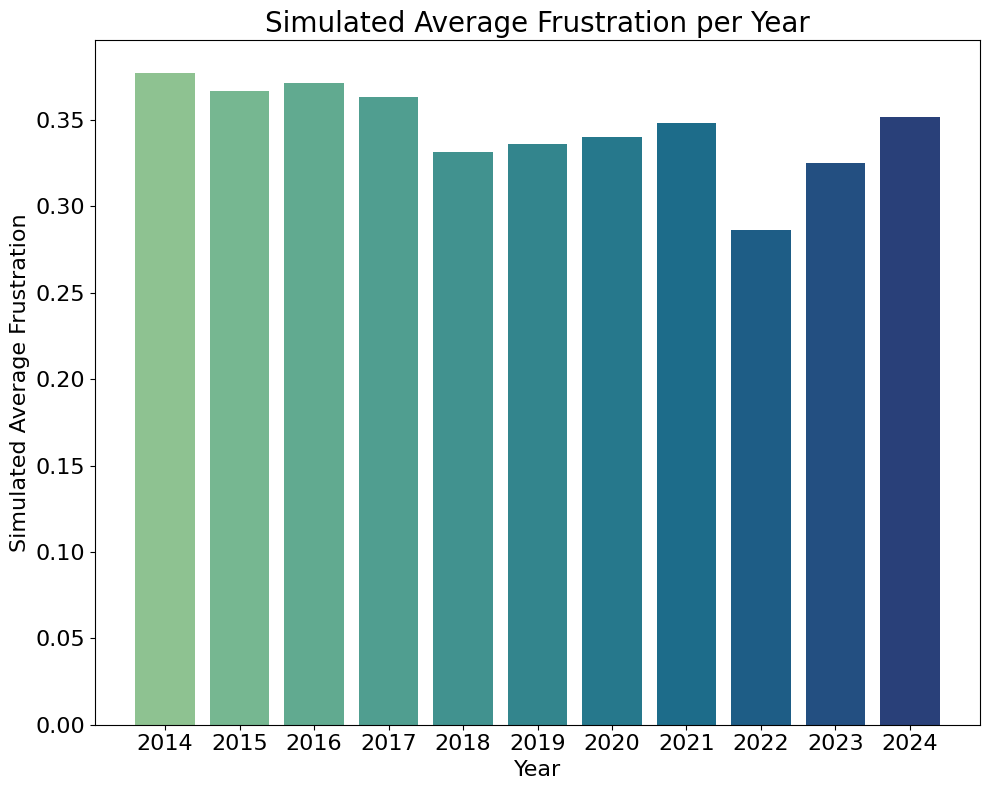

In [386]:
years = list(mean_frustrations_over_years_all_factors.keys())
frustration_means = list(mean_frustrations_over_years_all_factors.values())

palette = sns.color_palette("crest", len(years))
colors = palette.as_hex()

plt.figure(figsize=(10, 8))
plt.bar(years, frustration_means, color=colors)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Simulated Average Frustration", fontsize=16)
plt.title("Simulated Average Frustration per Year", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.tight_layout()
plt.savefig(result_dir.joinpath("mean_frustrations_over_years.pdf"), format="pdf")
plt.show()

### 7.3 Average Frustration by Region

This bar chart displays the simulated average frustration levels per region (country) for the years 2014 & 2024.

- Regions are sorted in descending order of frustration.
- Higher values indicate greater economic dissatisfaction, influenced by factors such as income inequality, unemployment and poverty rates.

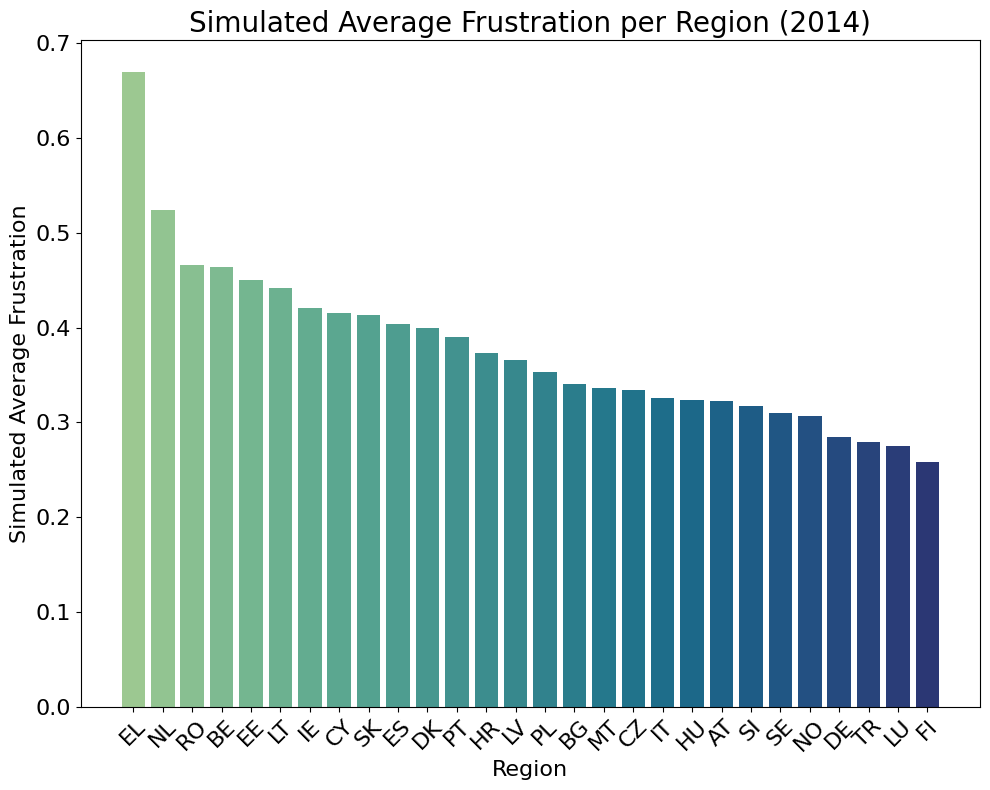

In [389]:
year = '2014'
frustration_series = mean_frustrations_dict_over_years_all_factors[year]
frustration_data = frustration_series.iloc[0]

sorted_frustration = dict(sorted(frustration_data.items(), key=lambda item: item[1], reverse=True))

region = list(sorted_frustration.keys())
frustration_mean = list(sorted_frustration.values())

plt.figure(figsize=(10, 8))
plt.bar(region, frustration_mean, color=sns.color_palette("crest", len(region)))
plt.xlabel("Region", fontsize=16)
plt.ylabel("Simulated Average Frustration", fontsize=16)
plt.title(f"Simulated Average Frustration per Region ({year})", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(result_dir.joinpath(f"mean_frustration_by_region_{year}.pdf"), format="pdf")
plt.show()

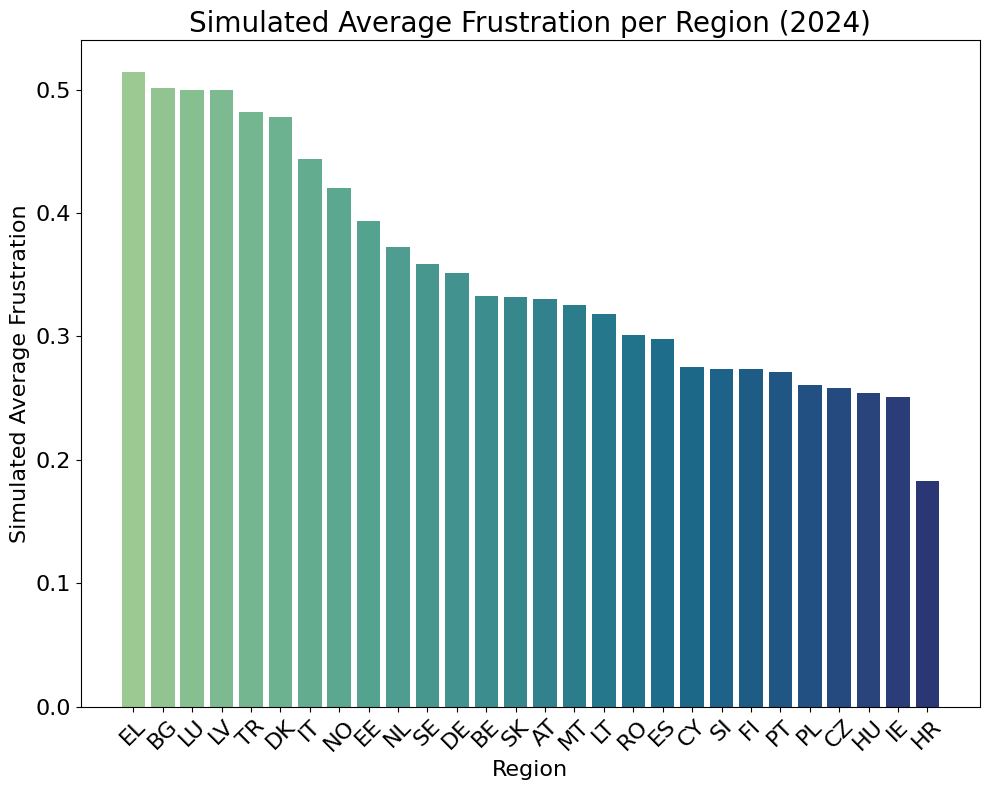

In [390]:
year = '2024'
frustration_series = mean_frustrations_dict_over_years_all_factors[year]
frustration_data = frustration_series.iloc[0]

sorted_frustration = dict(sorted(frustration_data.items(), key=lambda item: item[1], reverse=True))

region = list(sorted_frustration.keys())
frustration_mean = list(sorted_frustration.values())

plt.figure(figsize=(10, 8))
plt.bar(region, frustration_mean, color=sns.color_palette("crest", len(region)))
plt.xlabel("Region", fontsize=16)
plt.ylabel("Simulated Average Frustration", fontsize=16)
plt.title(f"Simulated Average Frustration per Region ({year})", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(result_dir.joinpath(f"mean_frustration_by_region_{year}.pdf"), format="pdf")
plt.show()

### 7.4 Average Opinions Over Time

This bar chart illustrates the average simulated opinion values across all countries for each year in the dataset.

- Opinion values range from 0 to 1, with 0.5 representing a neutral or centrist position.
- This visualization helps track shifts in collective opinion over time, potentially reflecting how economic conditions influence ideological centrality or extremity.


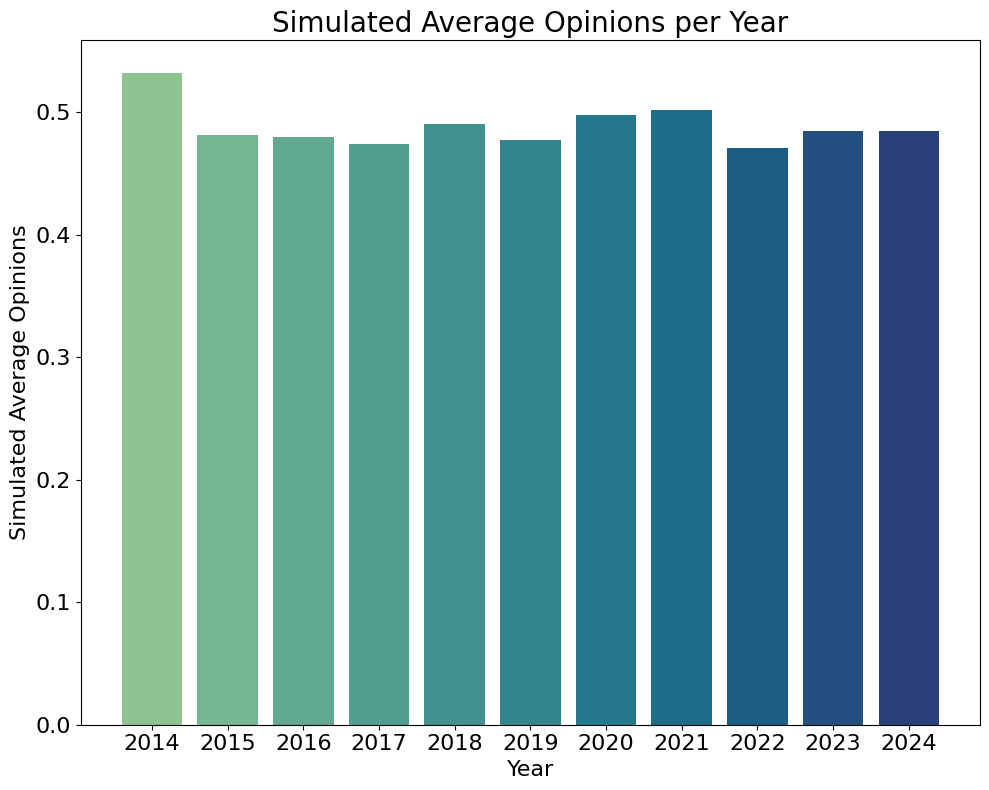

In [391]:
years = list(mean_opinions_over_years_all_factors.keys())
frustration_means = list(mean_opinions_over_years_all_factors.values())

palette = sns.color_palette("crest", len(years))
colors = palette.as_hex()

plt.figure(figsize=(10, 8))
plt.bar(years, frustration_means, color=colors)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Simulated Average Opinions", fontsize=16)
plt.title("Simulated Average Opinions per Year", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.tight_layout()
plt.savefig(result_dir.joinpath("mean_opinions_over_years.pdf"), format="pdf")
plt.show()

This bar chart shows the simulated average opinions across European regions in 2014.

- Each bar represents a region, ranked by its average opinion value in the simulation.
- Higher bars indicate regions with more positive or aligned opinions in the modeled scenario.
- The chart highlights regional variation in public sentiment, potentially influenced by socioeconomic factors.


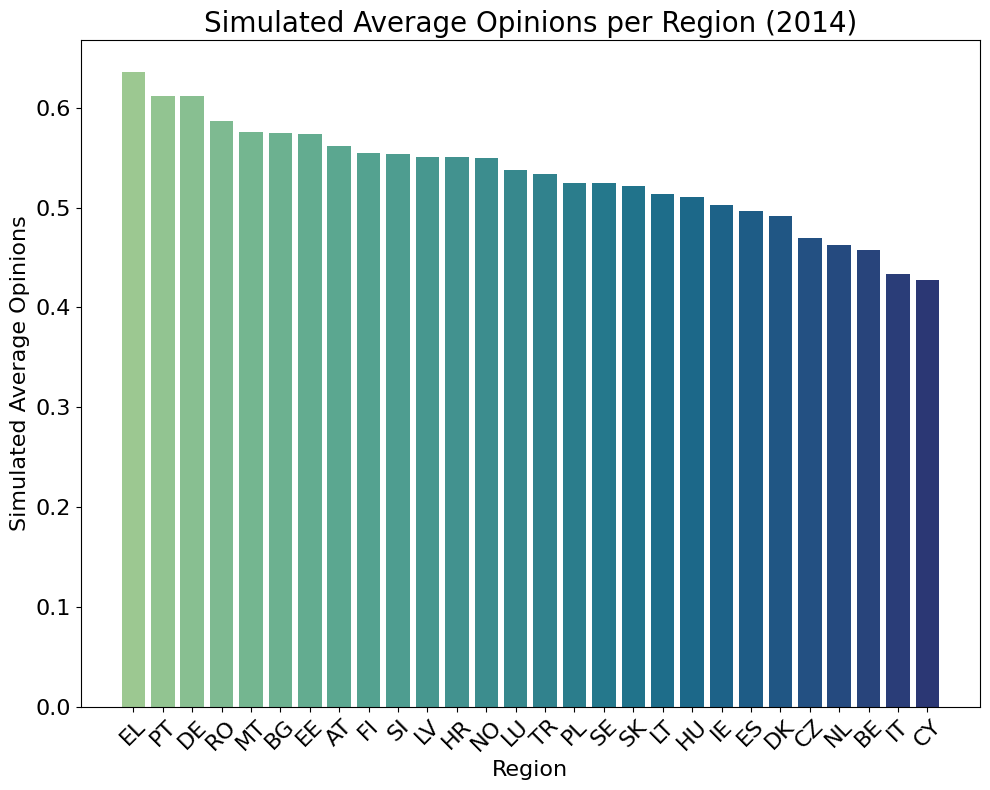

In [392]:
year = '2014'
opinion_series = mean_opinions_dict_over_years_all_factors[year]
opinion_data = opinion_series.iloc[0]

sorted_opinion = dict(sorted(opinion_data.items(), key=lambda item: item[1], reverse=True))

region = list(sorted_opinion.keys())
opinion_mean = list(sorted_opinion.values())

plt.figure(figsize=(10, 8))
plt.bar(region, opinion_mean, color=sns.color_palette("crest", len(region)))
plt.xlabel("Region", fontsize=16)
plt.ylabel("Simulated Average Opinions", fontsize=16)
plt.title(f"Simulated Average Opinions per Region ({year})", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(result_dir.joinpath(f"mean_opinions_by_region_{year}.pdf"), format="pdf")
plt.show()

### 7.5 Standard Deviation for the Opinion over time

This bar chart shows the simulated standard deviations of opinions across all regions for each year from 2014 to 2024.

- Each bar represents the variability in public opinion for a given year.
- Higher values indicate greater opinion divergence, while lower values suggest more consensus.
- The chart reveals how polarization or diversity of opinions evolves over time in the simulation.


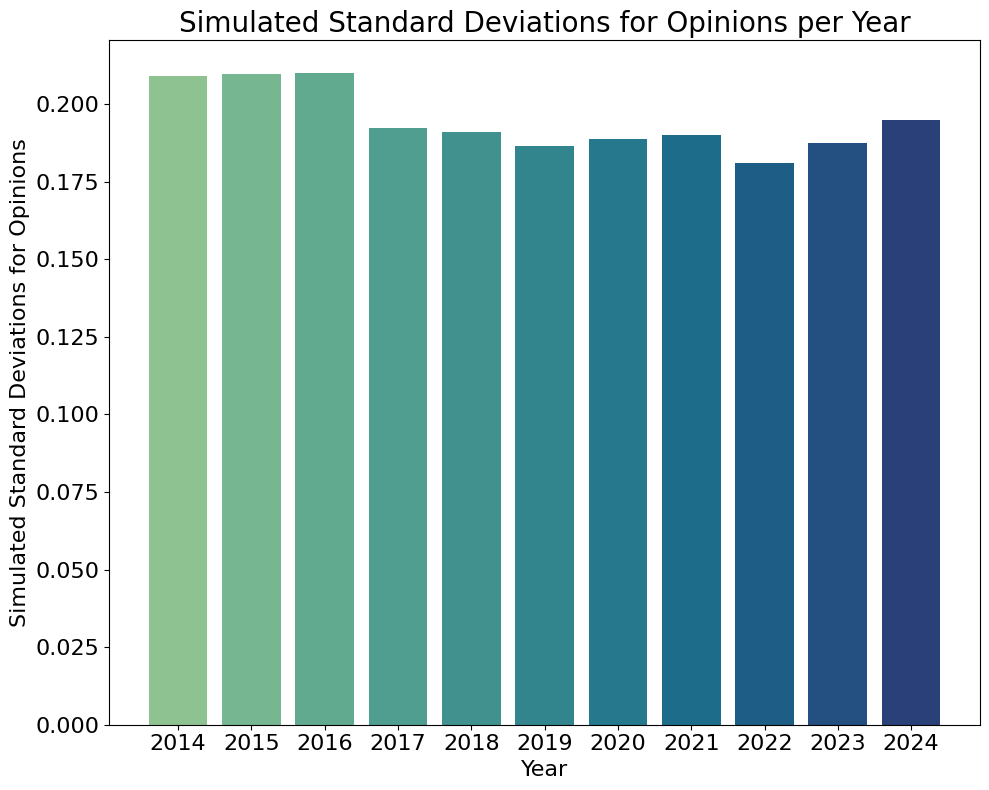

In [395]:
years = list(std_opinions_over_years_all_factors.keys())
opinion_std = list(std_opinions_over_years_all_factors.values())

palette = sns.color_palette("crest", len(years))
colors = palette.as_hex()

plt.figure(figsize=(10, 8))
plt.bar(years, opinion_std, color=colors)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Simulated Standard Deviations for Opinions", fontsize=16)
plt.title("Simulated Standard Deviations for Opinions per Year", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.tight_layout()
plt.savefig(result_dir.joinpath("std_opinions_over_years.pdf"), format="pdf")
plt.show()

This bar chart shows the simulated standard deviations of opinions across European regions in 2014.

- Each bar represents a region, with higher values indicating greater variability or polarization in simulated opinions.
- Lower bars suggest more consensus or uniformity within the regional population.
- The chart highlights regional differences in opinion diversity under the modeled scenario.


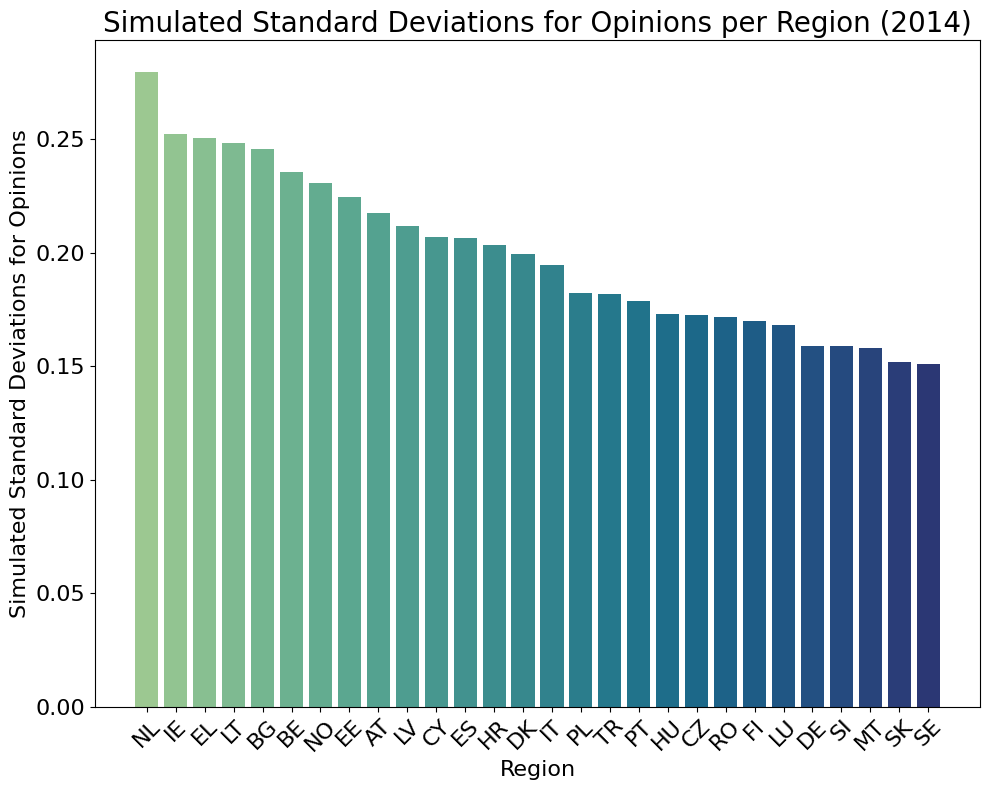

In [396]:
year = '2014'
opinion_series = std_opinions_dict_over_years_all_factors[year]
opinion_data = opinion_series.iloc[0]

sorted_opinion = dict(sorted(opinion_data.items(), key=lambda item: item[1], reverse=True))

region = list(sorted_opinion.keys())
opinion_std = list(sorted_opinion.values())

plt.figure(figsize=(10, 8))
plt.bar(region, opinion_std, color=sns.color_palette("crest", len(region)))
plt.xlabel("Region", fontsize=16)
plt.ylabel("Simulated Standard Deviations for Opinions", fontsize=16)
plt.title(f"Simulated Standard Deviations for Opinions per Region ({year})", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(result_dir.joinpath(f"std_opinions_by_region_{year}.pdf"), format="pdf")
plt.show()

### 7.6 Baseline: Mean opinion over time

This bar chart shows the simulated average opinions across all regions for each year from 2014 to 2024, in a scenario without frustration effects.

- Each bar represents the mean simulated opinion value in a given year.
- The values remain relatively stable over time, with slight fluctuations.
- The absence of frustration suggests more consistent opinion dynamics across the simulation period.


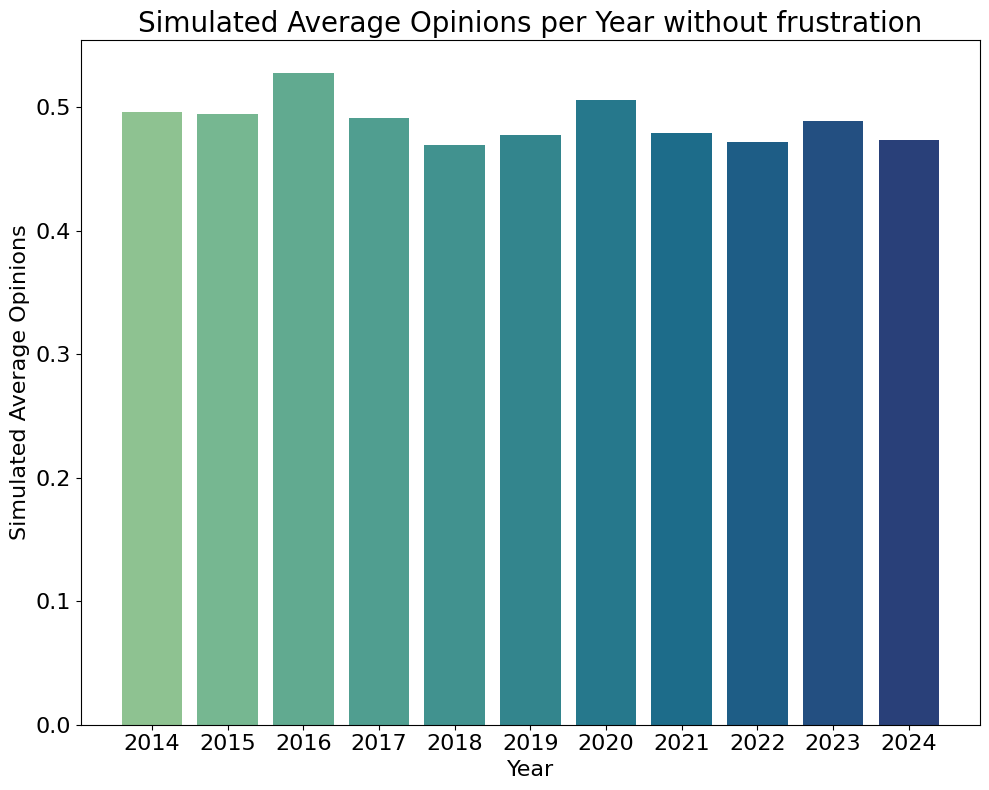

In [398]:
years = list(mean_opinions_over_years_no_frustration.keys())
opinion_mean = list(mean_opinions_over_years_no_frustration.values())

palette = sns.color_palette("crest", len(years))
colors = palette.as_hex()

plt.figure(figsize=(10, 8))
plt.bar(years, opinion_mean, color=colors)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Simulated Average Opinions", fontsize=16)
plt.title("Simulated Average Opinions per Year without frustration", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.tight_layout()
plt.savefig(result_dir.joinpath("mean_opinions_over_years_no_frustration.pdf"), format="pdf")
plt.show()

This bar chart shows simulated average opinions across European regions in 2014 under a scenario without frustration effects.

- Each bar represents a region, ranked by its mean opinion value from highest to lowest.
- Regions on the left exhibit more favorable or aligned opinions, while those on the right show lower average sentiment.
- The chart highlights regional differences in simulated public attitudes in a stable (non-frustrated) environment.


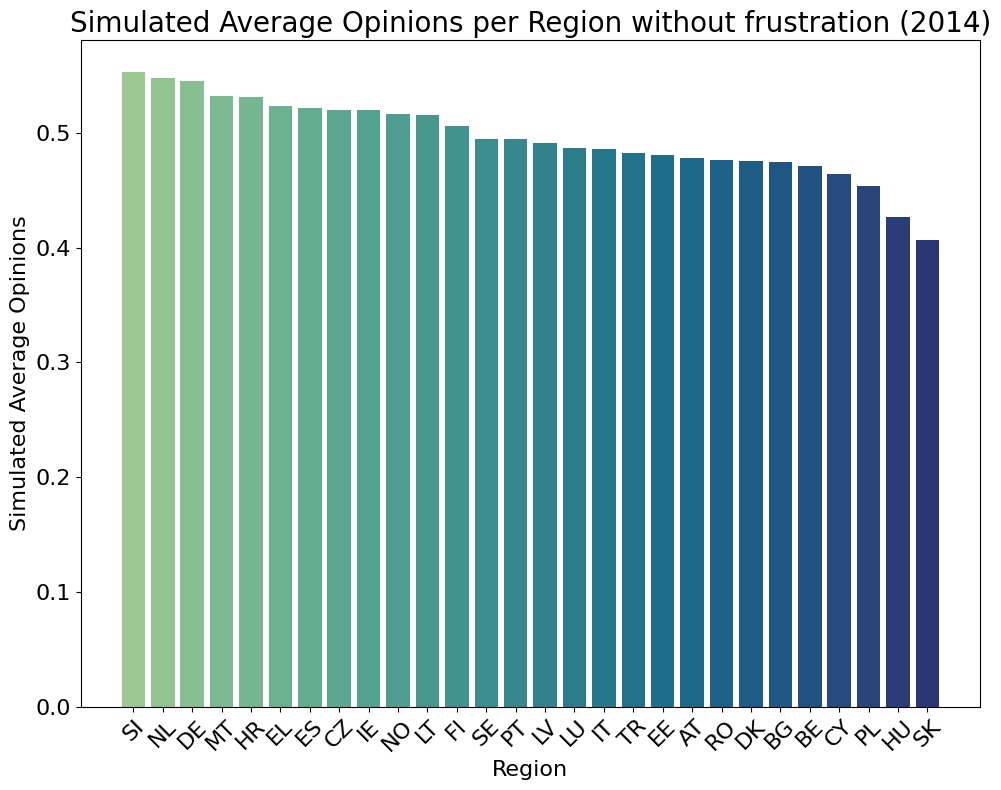

In [399]:
year = '2014'
opinion_series = mean_opinions_dict_over_years_no_frustration[year]
opinion_data = opinion_series.iloc[0]

sorted_opinion = dict(sorted(opinion_data.items(), key=lambda item: item[1], reverse=True))

region = list(sorted_opinion.keys())
opinion_mean = list(sorted_opinion.values())

plt.figure(figsize=(10, 8))
plt.bar(region, opinion_mean, color=sns.color_palette("crest", len(region)))
plt.xlabel("Region", fontsize=16)
plt.ylabel("Simulated Average Opinions", fontsize=16)
plt.title(f"Simulated Average Opinions per Region without frustration ({year})", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(result_dir.joinpath(f"mean_opinions_by_region_{year}_no_frustration.pdf"), format="pdf")
plt.show()

### 7.7 Baseline: Standard deviation for the opinion over time

This bar chart shows the simulated standard deviations of opinions across all regions from 2014 to 2024 in a scenario without frustration effects.

- Each bar indicates the level of opinion variability in a given year.
- Lower standard deviations suggest greater consensus or stability in public sentiment.
- The generally declining trend reflects increasing opinion uniformity over time when frustration is excluded from the model.


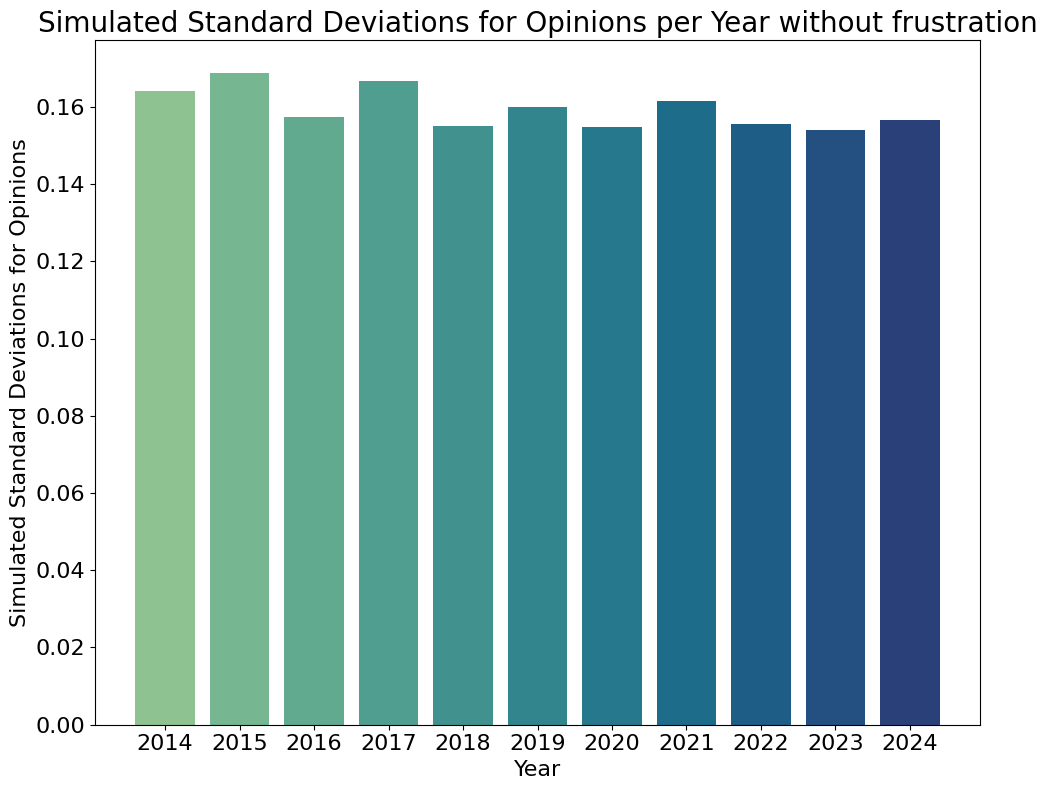

In [400]:
years = list(std_opinions_over_years_no_frustration.keys())
opinion_std = list(std_opinions_over_years_no_frustration.values())

palette = sns.color_palette("crest", len(years))
colors = palette.as_hex()

plt.figure(figsize=(10, 8))
plt.bar(years, opinion_std, color=colors)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Simulated Standard Deviations for Opinions", fontsize=16)
plt.title("Simulated Standard Deviations for Opinions per Year without frustration", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.tight_layout()
plt.savefig(result_dir.joinpath("std_opinions_over_years_no_frustration.pdf"), format="pdf")
plt.show()

This bar chart shows the simulated standard deviations of opinions across European regions in 2014, without frustration effects.

- Each bar represents the variability of opinions within a region, with higher values indicating more diverse or polarized views.
- Regions like Romania and Estonia exhibit the highest opinion divergence, while Sweden and Denmark show the lowest variability.
- The chart highlights significant regional differences in opinion consistency under stable model conditions.


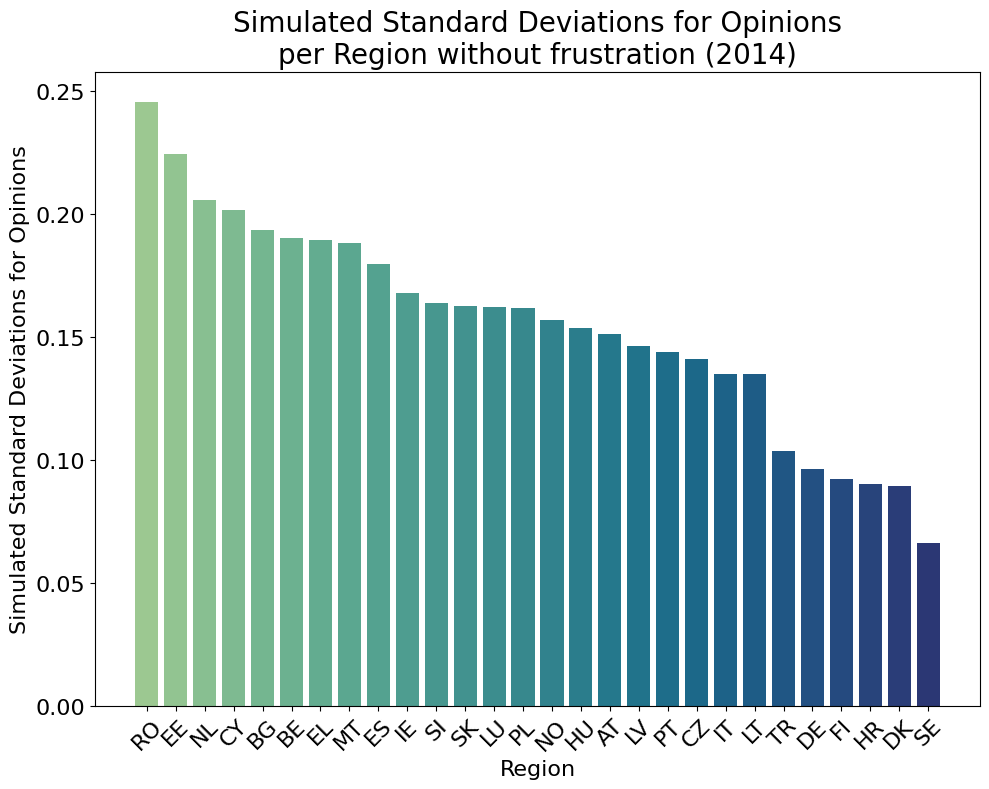

In [401]:
year = '2014'
opinion_series = std_opinions_dict_over_years_no_frustration[year]
opinion_data = opinion_series.iloc[0]

sorted_opinion = dict(sorted(opinion_data.items(), key=lambda item: item[1], reverse=True))

region = list(sorted_opinion.keys())
opinion_std = list(sorted_opinion.values())

plt.figure(figsize=(10, 8))
plt.bar(region, opinion_std, color=sns.color_palette("crest", len(region)))
plt.xlabel("Region", fontsize=16)
plt.ylabel("Simulated Standard Deviations for Opinions", fontsize=16)
plt.title(f"Simulated Standard Deviations for Opinions\nper Region without frustration ({year})", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(result_dir.joinpath(f"std_opinions_by_region_{year}_no_frustration.pdf"), format="pdf")
plt.show()

### 7.8 Simulated Poverty Over Time

This bar chart shows the simulated average poverty rate across all countries for each year.

- Poverty is defined here as the proportion of agents earning below 60% of the regional mean income.
- The chart highlights changes in modeled poverty levels over time, based on varying income distributions and socioeconomic conditions.


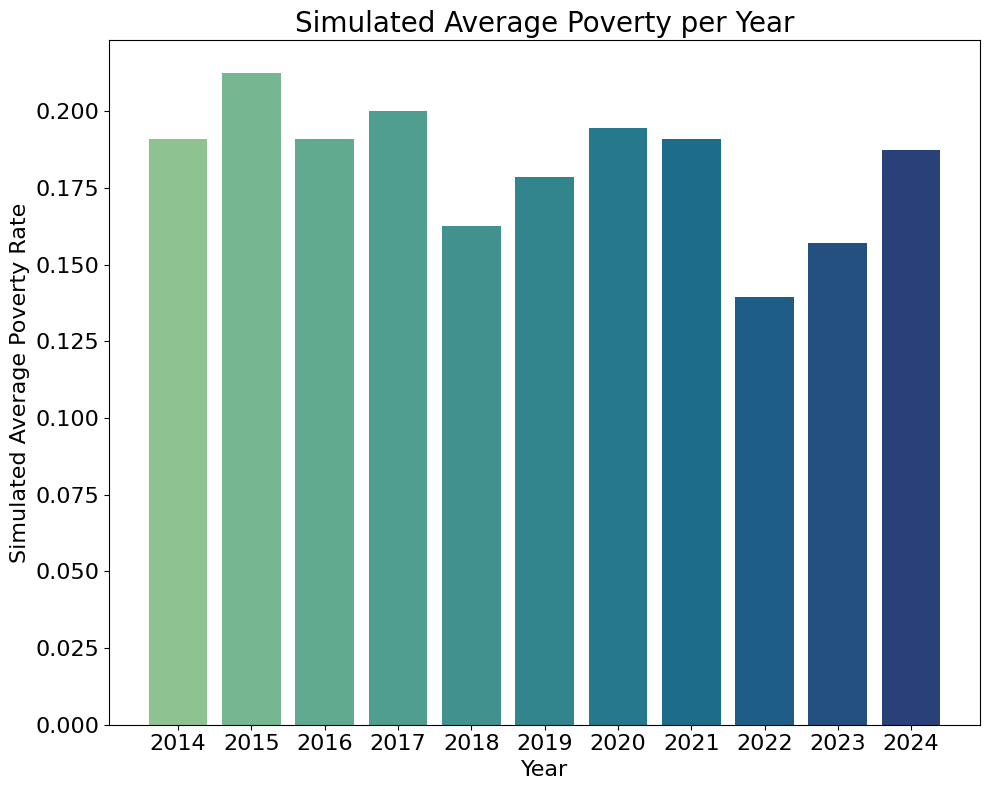

In [402]:
years = list(mean_opinions_over_years_all_factors.keys())
frustration_means = list(poverty_mean_all_factors.values())

palette = sns.color_palette("crest", len(years))
colors = palette.as_hex()

plt.figure(figsize=(10, 8))
plt.bar(years, frustration_means, color=colors)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Simulated Average Poverty Rate", fontsize=16)
plt.title("Simulated Average Poverty per Year", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.tight_layout()
plt.savefig(result_dir.joinpath("mean_poverty_over_years.pdf"), format="pdf")
plt.show()

### 7.9 Simulated Poverty by Region (2014)

This bar chart presents the simulated average poverty rate per region (country) for the year 2014.


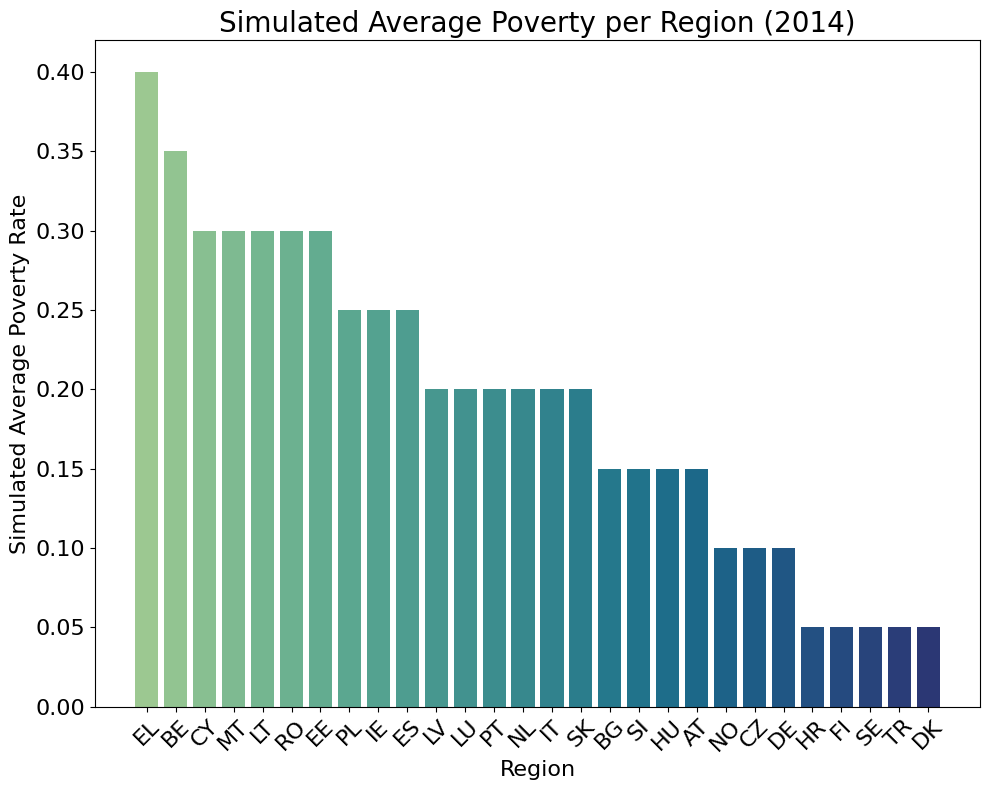

In [404]:
year = '2014'
poverty_series = poverty_dict_all_factors[year]
poverty_data = poverty_series.iloc[0]

sorted_poverty = dict(sorted(poverty_data.items(), key=lambda item: item[1], reverse=True))

region = list(sorted_poverty.keys())
poverty_mean = list(sorted_poverty.values())

plt.figure(figsize=(10, 8))
plt.bar(region, poverty_mean, color=sns.color_palette("crest", len(region)))
plt.xlabel("Region", fontsize=16)
plt.ylabel("Simulated Average Poverty Rate", fontsize=16)
plt.title(f"Simulated Average Poverty per Region ({year})", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(result_dir.joinpath(f"mean_poverty_by_region_{year}.pdf"), format="pdf")
plt.show()

### 7.10 Eurostat At-Risk-of-Poverty Rate by Country (2014)

This horizontal bar chart displays the official at-risk-of-poverty rates for European countries in 2014, based on Eurostat data.

- Countries are sorted in descending order of poverty rate.
- The rate represents the percentage of individuals earning below 60% of the national median income.

This plot provides a real-world reference point to compare against simulated poverty estimates.


/tmp/ipykernel_51484/2771634972.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_poverty_2014, x=year, y="geo", palette="crest")


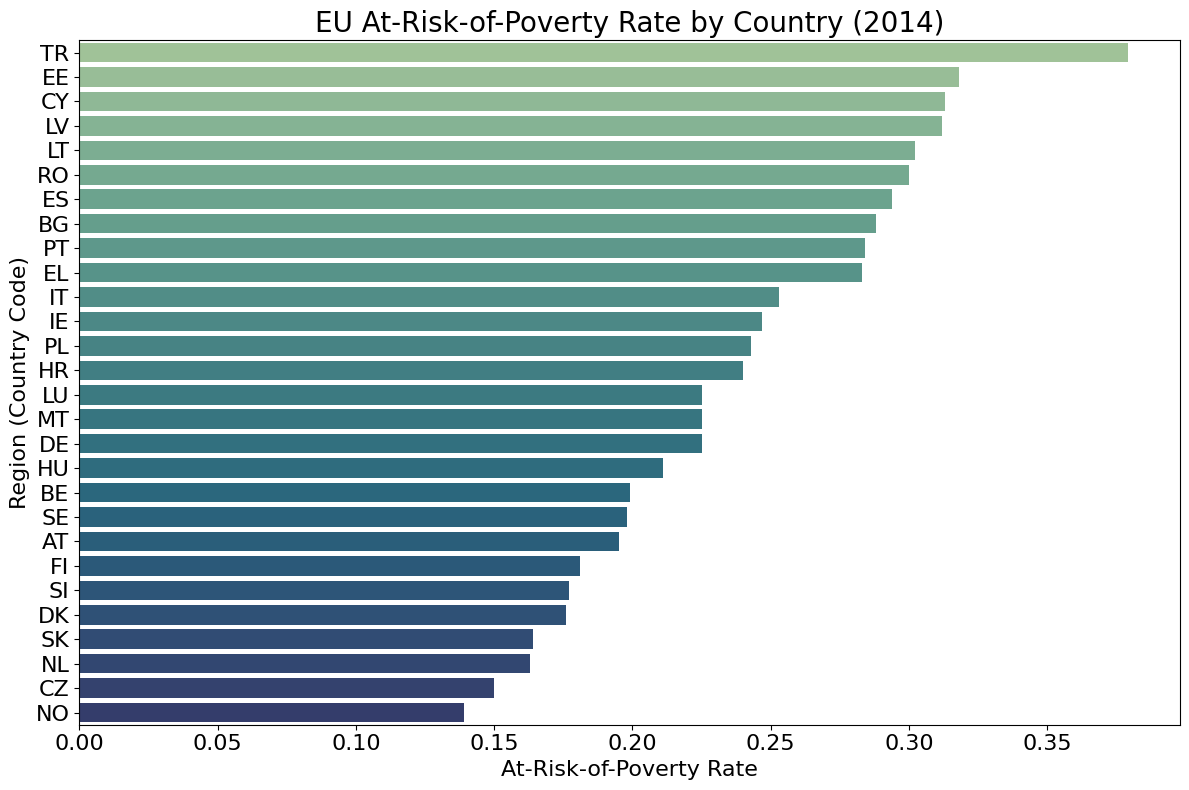

In [405]:
df_poverty_2014 = df_processed_at_risk_of_poverty[["geo", year]].dropna().sort_values(year, ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=df_poverty_2014, x=year, y="geo", palette="crest")
plt.xlabel("At-Risk-of-Poverty Rate", fontsize=16)
plt.ylabel("Region (Country Code)", fontsize=16)
plt.title(f"EU At-Risk-of-Poverty Rate by Country ({year})", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.tight_layout()
plt.savefig(result_dir.joinpath(f"ground_truth_poverty_rates_{year}.pdf"), format="pdf")
plt.show()

## 8. Additional Plots

Import libraries to download, extract, and handle geospatial data using GeoPandas.

In [45]:
import geopandas as gpd
import requests, zipfile, io, os
from scipy.stats import pearsonr
from adjustText import adjust_text

### 8.1 Load Europe Map
Basic function to load map of europe and do a country mapping to 3 chars

In [31]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
extract_dir = "ne_admin_0"

if not os.path.exists(extract_dir):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_dir)

world = gpd.read_file(f"{extract_dir}/ne_110m_admin_0_countries.shp")
europe = world[
    (world["CONTINENT"] == "Europe") &
    (world["NAME"] != "Russia")
]

# Mapping from EU country codes to ISO A3
alpha2_to_alpha3 = {
    "AL": "ALB", "AT": "AUT", "BE": "BEL", "BG": "BGR", "CH": "CHE", "CY": "CYP",
    "CZ": "CZE", "DE": "DEU", "DK": "DNK", "EE": "EST", "EL": "GRC", "ES": "ESP",
    "FI": "FIN", "FR": "FRA", "HR": "HRV", "HU": "HUN", "IE": "IRL", "IS": "ISL",
    "IT": "ITA", "LT": "LTU", "LU": "LUX", "LV": "LVA", "MT": "MLT", "NL": "NLD",
    "NO": "NOR", "PL": "POL", "PT": "PRT", "RO": "ROU", "SE": "SWE", "SI": "SVN",
    "SK": "SVK", "TR": "TUR", "UK": "GBR", "RS": "SRB", "ME": "MNE", "MK": "MKD"
}

### 8.1 Preprocessing Routines for additional Plots

Transforms a wide Eurostat DataFrame into a long format, renames the geographical column to "geo", filters out non-EU entities and ensures the "year" column is numeric.

In [ ]:
def melt_eurostat_df(df: pd.DataFrame) -> pd.DataFrame:

    year_cols = [col for col in df.columns if str(col).isdigit() and len(str(col)) == 4]
    id_vars = [col for col in df.columns if col not in year_cols]
    df_long = df.melt(id_vars=id_vars, var_name="year", value_name="value")
    df_long = df_long[df_long["year"].apply(lambda x: str(x).isdigit())]
    df_long["year"] = df_long["year"].astype(int)
    for col in id_vars:
        if "geo" in col.lower():
            df_long.rename(columns={col: "geo"}, inplace=True)
            df_long = df_long[~df_long["geo"].isin(non_eu_entities)]  
    return df_long

Returns a filtered copy of the input DataFrame containing only rows for the specified year.

In [ ]:

def get_data_for_year(df_long: pd.DataFrame, year: int) -> pd.DataFrame:
    df = df_long.copy()
    df = df[
        (df["year"] == year)
    ]
    return df

Returns a filtered copy of the DataFrame with rows where the "year" is between year1 and year2 (inclusive).

In [ ]:
def get_data_for_years(df_long: pd.DataFrame, year1: int, year2: int) -> pd.DataFrame:
    df = df_long.copy()
    df = df[
        (df["year"] >= year1) &
        (df["year"] <= year2)
    ]
    return df

Merges income and Gini data by country and calculates an inequality-weighted income metric.

In [47]:
def merge_income_and_gini(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    df = df1.merge(df2[["iso_a3", "gini"]], on="iso_a3", how="inner")
    df["Inequiety_x_Income"] = df["value"] * (df["gini"] / 100)
    return df

The function merges income and housing cost datasets on the `iso_a3` country code and calculates the **available income** by subtracting the housing cost share from the total income.


In [49]:
def merge_income_and_cost(income_df: pd.DataFrame, cost_df: pd.DataFrame) -> pd.DataFrame:
    df = income_df.merge(cost_df[["iso_a3", "cost_share"]], on="iso_a3", how="left")
    df["available_income"] = df["value"] * (1 - df["cost_share"] / 100)
    return df

This function merges unemployment and Gini data by country and computes a simple inequality-weighted unemployment metric.


In [57]:
def merge_unemp_and_gini(income_df: pd.DataFrame, cost_df: pd.DataFrame) -> pd.DataFrame:
    df = income_df.merge(cost_df[["iso_a3", "gini"]], on="iso_a3", how="inner")
    df["Inequiety_x_Income"] = df["unemp"] * (df["gini"] / 100)
    return df

Merges poverty and Gini data by country and computes an inequality-weighted poverty metric.

In [60]:
def merge_poverty_and_gini(income_df: pd.DataFrame, cost_df: pd.DataFrame) -> pd.DataFrame:
    df = income_df.merge(cost_df[["iso_a3", "gini"]], on="iso_a3", how="inner")
    df["Inequiety_x_Income"] = df["pov"] * (df["gini"] / 100)
    return df

The code processes multiple Eurostat datasets by:

1. **Melting each dataset** into long format using `melt_eurostat_df`.
2. **Filtering** the data based on target demographic and indicator values (e.g. `age`, `sex`, `unit`, etc.).
3. **Mapping country codes** from 2-letter (alpha-2) to 3-letter (alpha-3) using the `alpha2_to_alpha3` mapping.
4. **Renaming value columns** to meaningful names like `gini`, `pov`, `cost_share`, and `unemp`.

Each `df_*_long` represents a cleaned and reshaped version of the original dataset, ready for analysis or merging.

In [36]:
df_income_long = melt_eurostat_df(df_orig_mean_median_income)
df_income_long = df_income_long[
        (df_income_long["age"] == TARGET_AGE) &
        (df_income_long["sex"] == TARGET_SEX) &
        (df_income_long["unit"] == TARGET_MEAN_INCOME_UNIT) &
        (df_income_long["indic_il"] == TARGET_MEAN_INCOME_INDIC)
]
df_income_long["iso_a3"] = df_income_long["geo"].map(alpha2_to_alpha3)

df_gini_long = melt_eurostat_df(df_orig_gini_coefficient)
df_gini_long = df_gini_long[(df_gini_long["age"] == TARGET_AGE)]
df_gini_long["iso_a3"] = df_gini_long["geo"].map(alpha2_to_alpha3)
df_gini_long = df_gini_long.rename(columns={"value": "gini"})

df_poverty_long = melt_eurostat_df(df_orig_at_risk_of_poverty)
df_poverty_long = df_poverty_long[
    (df_poverty_long["sex"] == TARGET_SEX) &
    (df_poverty_long["age"] == TARGET_AGE) &
    (df_poverty_long["indic_il"] == TARGET_POVERTY_INDIC) &
    (df_poverty_long["unit"] == TARGET_POVERTY_UNIT)]
df_poverty_long["iso_a3"] = df_poverty_long["geo"].map(alpha2_to_alpha3)
df_poverty_long = df_poverty_long.rename(columns={"value": "pov"})

df_costs_long = melt_eurostat_df(df_orig_household_cost_shares)
df_costs_long = df_costs_long[
        (df_costs_long["hhtyp"] == TARGET_HOUSING_TYPE) &
        (df_costs_long["incgrp"] == TARGET_HOUSING_INCOME_GROUP) &
        (df_costs_long["unit"] == TARGET_POVERTY_UNIT)]
df_costs_long["iso_a3"] = df_costs_long["geo"].map(alpha2_to_alpha3)
df_costs_long = df_costs_long.rename(columns={"value": "cost_share"})

df_unemp_long = melt_eurostat_df(df_orig_unemployment_rate)
df_unemp_long = df_unemp_long[
    (df_unemp_long["age"] == TARGET_UNEMPLOYMENT_AGES) &
    (df_unemp_long["sex"] == TARGET_SEX) &
    (df_unemp_long["unit"] == TARGET_UNEMPLOYMENT_UNIT)]
df_unemp_long["iso_a3"] = df_unemp_long["geo"].map(alpha2_to_alpha3)
df_unemp_long = df_unemp_long.rename(columns={"value": "unemp"})

### 8.2 Income related plots
Following plot shows the available income (income reduced by cost percentage for living)

This side-by-side choropleth map shows the estimated **available income** (in EUR) **after housing costs** across European countries for the years **2019** and **2024**.

- **Darker blue shades** indicate higher available income.
- **Lighter yellow shades** represent lower available income.
- **Grey areas** indicate missing or unavailable data.

The comparison highlights regional differences and potential shifts in economic conditions or housing cost burdens between the two years.


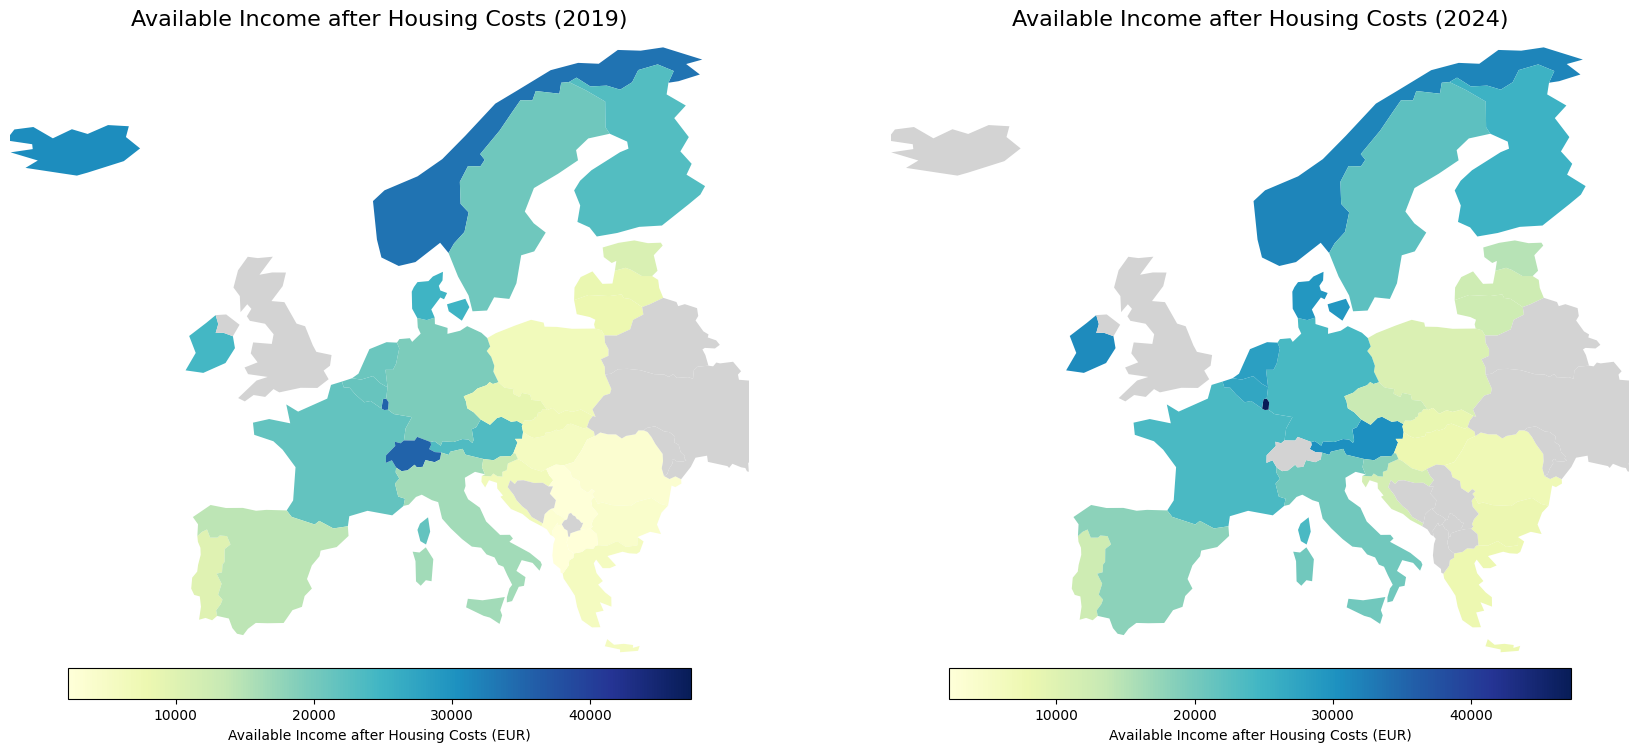

In [50]:
df_income_1 = merge_income_and_cost(get_data_for_year(df_income_long, 2019), get_data_for_year(df_costs_long, 2019))
df_income_2 = merge_income_and_cost(get_data_for_year(df_income_long, 2024), get_data_for_year(df_costs_long, 2024))


combined_values = pd.concat([df_income_1["available_income"], df_income_2["available_income"]])
vmin = combined_values.min()
vmax = combined_values.max()


map_1 = europe.merge(df_income_1, left_on="ADM0_A3", right_on="iso_a3", how="left")
map_2 = europe.merge(df_income_2, left_on="ADM0_A3", right_on="iso_a3", how="left")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for ax, map_df, year in zip(axes, [map_1, map_2], [2019, 2024]):
    map_df.plot(
        column="available_income",
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        cmap="YlGnBu",
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "No data"},
        legend_kwds={
            "label": "Available Income after Housing Costs (EUR)",
            "orientation": "horizontal",
            "shrink": 0.7,
            "pad": 0,
            "aspect": 20
        }
    )
    ax.set_xlim(-24, 35)
    ax.set_ylim(34, 72)
    ax.set_title(f"Available Income after Housing Costs ({year})", fontsize=16)
    ax.axis("off")

plt.tight_layout()
plt.savefig("available_income_2019_2024.png", dpi=300, bbox_inches="tight")
plt.show()

### 8.3 Correlation for income and costs

This scatter plot shows the relationship between median income and housing cost share across European countries in 2024.

- Each point represents a country, with the housing cost share plotted against median income levels.
- The regression line and confidence interval illustrate overall trends

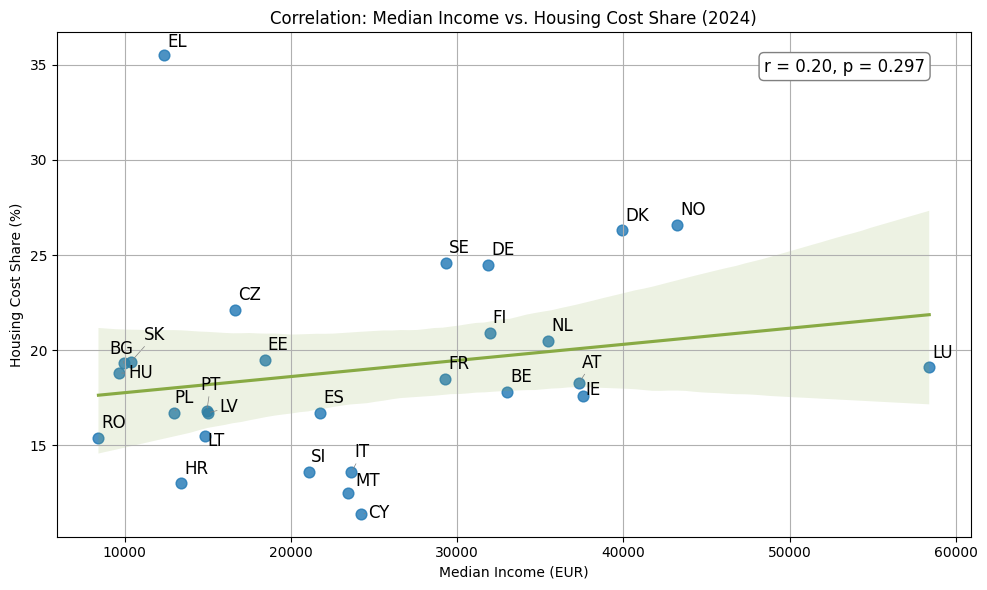

In [51]:
df_income_1 = merge_income_and_cost(get_data_for_year(df_income_long, 2024), get_data_for_year(df_costs_long, 2024))
df_income_1 = df_income_1.dropna()

r, p_value = pearsonr(df_income_1["value"], df_income_1["cost_share"])
corr_label = f"r = {r:.2f}, p = {p_value:.3f}"

plt.figure(figsize=(10, 6))
sns.regplot(data=df_income_1, x="value", y="cost_share", scatter_kws={"s": 60}, line_kws={"color": "#8a4"})

texts = []
for i, row in df_income_1.iterrows():
    texts.append(plt.text(row["value"], row["cost_share"], row["geo"], fontsize=12, ha="left", va="bottom"))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.text(
    0.95, 0.95, corr_label,
    transform=plt.gca().transAxes,
    fontsize=12,
    ha='right', va='top',
    bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.3')
)
plt.title(f"Correlation: Median Income vs. Housing Cost Share ({year})")
plt.xlabel("Median Income (EUR)")
plt.ylabel("Housing Cost Share (%)")
plt.grid(True)
plt.tight_layout()
plt.savefig("corr_income_costs_2024.png", dpi=300, bbox_inches="tight")
plt.show()

### 8.4 Correlation Income vs. Gini

This scatter plot shows the relationship between median income and the Gini index (inequality) across European countries in 2024.

- Each point represents a country, plotting inequality (Gini index) against median income..
- A trend line and confidence interval visualize the overall direction and variability of the relationship.

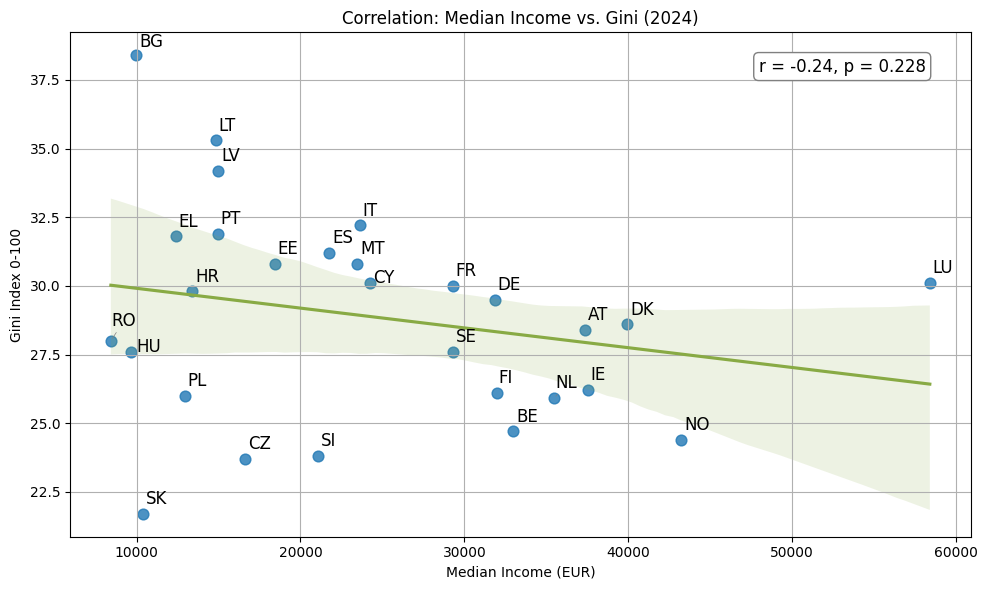

In [52]:
df_income_1 = merge_income_and_gini(get_data_for_year(df_income_long, 2024), get_data_for_year(df_gini_long,2024))
df_income_1 = df_income_1.dropna()

r, p_value = pearsonr(df_income_1["value"], df_income_1["gini"])
corr_label = f"r = {r:.2f}, p = {p_value:.3f}"

plt.figure(figsize=(10, 6))
sns.regplot(data=df_income_1, x="value", y="gini", scatter_kws={"s": 60}, line_kws={"color": "#8a4"})

texts = []
for i, row in df_income_1.iterrows():
    texts.append(plt.text(row["value"], row["gini"], row["geo"], fontsize=12, ha="left", va="bottom"))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.text(
    0.95, 0.95, corr_label,
    transform=plt.gca().transAxes,
    fontsize=12,
    ha='right', va='top',
    bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.3')
)
plt.title(f"Correlation: Median Income vs. Gini ({year})")
plt.xlabel("Median Income (EUR)")
plt.ylabel("Gini Index 0-100")
plt.grid(True)
plt.tight_layout()

plt.savefig("income_gini_2024.png", dpi=300, bbox_inches="tight")
plt.show()

### 8.5 Unemployment in Europe

This map shows unemployment rates across European countries in 2019 and 2024.

- Darker shades represent higher unemployment percentages, while lighter shades indicate lower rates.
- Grey areas reflect missing or unavailable data for that year.
- The visualization allows for direct comparison of regional labor market changes over time.


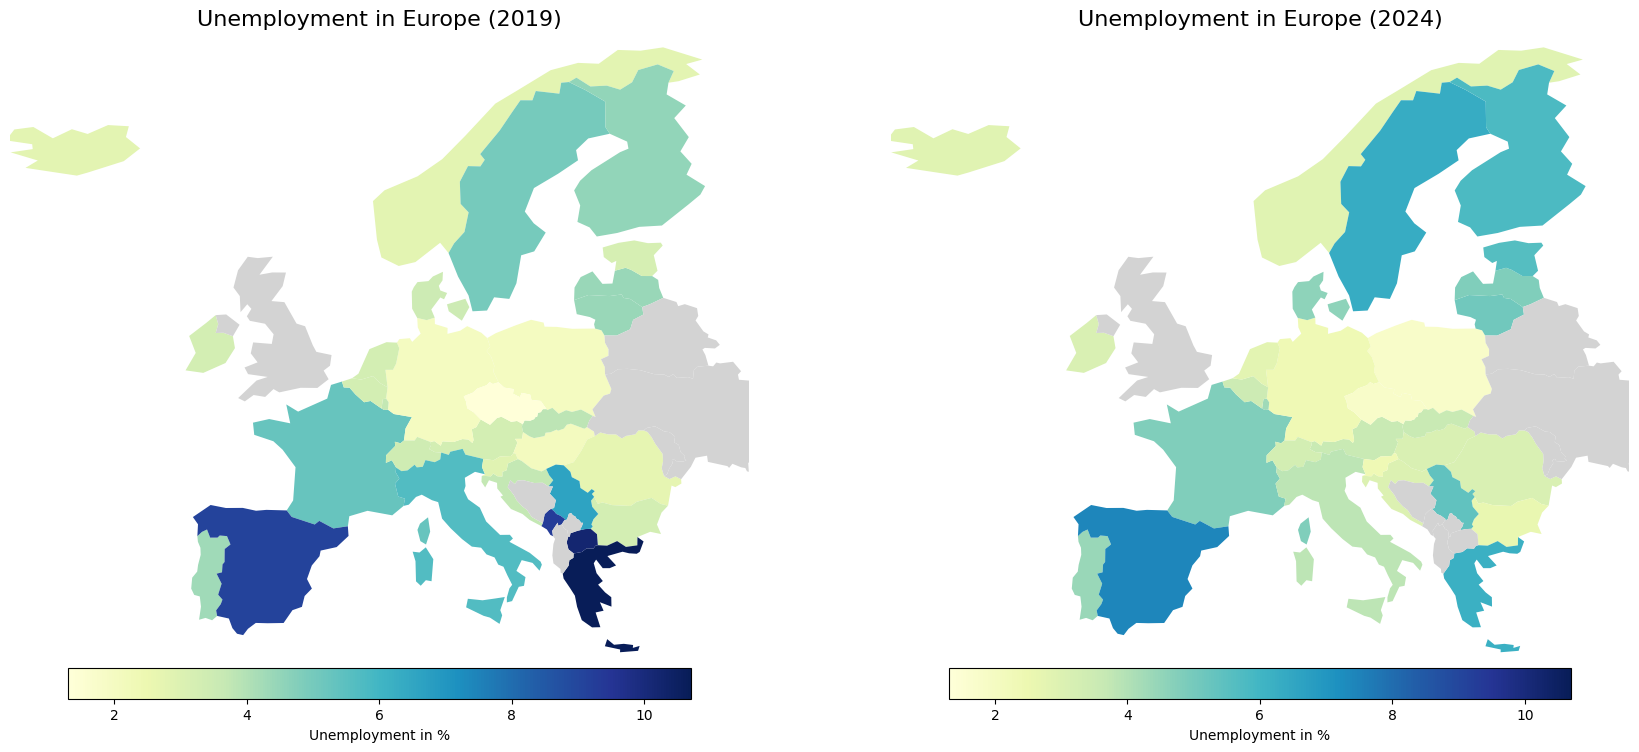

In [53]:
df_1 = get_data_for_year(df_unemp_long, 2019)
df_2 = get_data_for_year(df_unemp_long, 2024)

df_1["unemp"] = df_1["unemp"].astype(str).str.replace(",", ".").astype(float)
df_2["unemp"] = df_2["unemp"].astype(str).str.replace(",", ".").astype(float)

combined_values = pd.concat([df_1["unemp"], df_2["unemp"]])
vmin = combined_values.min()
vmax = combined_values.max()

# Merge with geo data
map_1 = europe.merge(df_1, left_on="ADM0_A3", right_on="iso_a3", how="left")
map_2 = europe.merge(df_2, left_on="ADM0_A3", right_on="iso_a3", how="left")

# Plot both maps
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for ax, map_df, year in zip(axes, [map_1, map_2], [2019, 2024]):
    map_df.plot(
        column="unemp",
        ax=ax,
        cmap="YlGnBu",
        vmin=vmin,
        vmax=vmax,
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "No data"},
        legend_kwds={
            "label": "Unemployment in %",
            "orientation": "horizontal",
            "shrink": 0.7,
            "pad": 0,
            "aspect": 20
        }
    )
    ax.set_xlim(-24, 35)
    ax.set_ylim(34, 72)
    ax.set_title(f"Unemployment in Europe ({year})", fontsize=16)
    ax.axis("off")

plt.tight_layout()
plt.savefig("unemp_2019_2024.png", dpi=300, bbox_inches="tight")
plt.show()

This scatter plot shows the relationship between unemployment rate and the Gini index (inequality) across European countries in 2024.

- Each point represents a country, comparing unemployment levels to income inequality.
- The trend line and confidence band visualize the direction and uncertainty of the relationship.


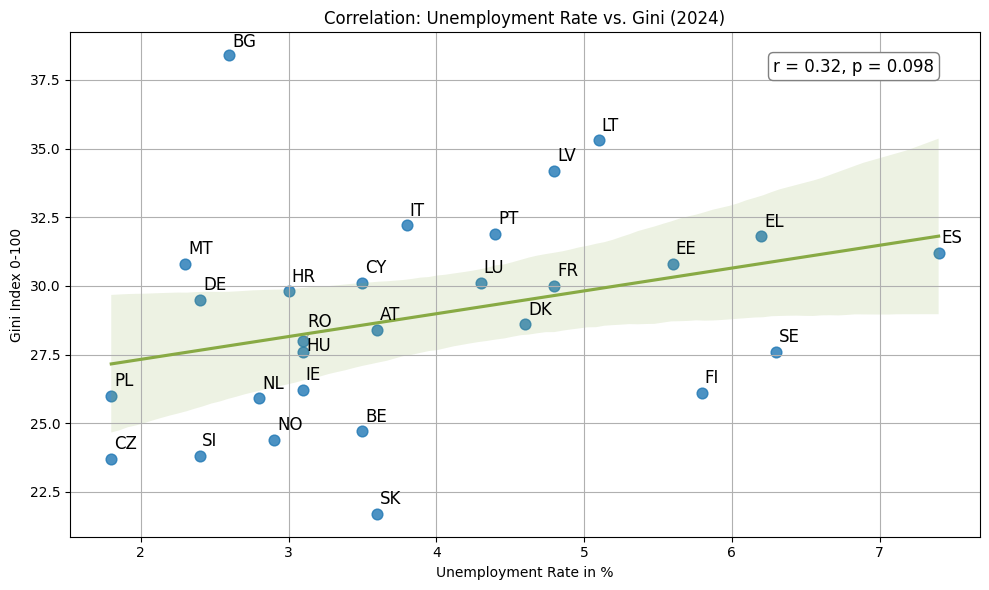

In [58]:
df_income_1 = merge_unemp_and_gini(get_data_for_year(df_unemp_long, 2024), get_data_for_year(df_gini_long, 2024))
df_income_1 = df_income_1.dropna()

r, p_value = pearsonr(df_income_1["unemp"], df_income_1["gini"])
corr_label = f"r = {r:.2f}, p = {p_value:.3f}"

plt.figure(figsize=(10, 6))
sns.regplot(data=df_income_1, x="unemp", y="gini", scatter_kws={"s": 60}, line_kws={"color": "#8a4"})

texts = []
for i, row in df_income_1.iterrows():
    texts.append(plt.text(row["unemp"], row["gini"], row["geo"], fontsize=12, ha="left", va="bottom"))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.text(
    0.95, 0.95, corr_label,
    transform=plt.gca().transAxes,
    fontsize=12,
    ha='right', va='top',
    bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.3')
)
plt.title(f"Correlation: Unemployment Rate vs. Gini ({year})")
plt.xlabel("Unemployment Rate in %")
plt.ylabel("Gini Index 0-100")
plt.grid(True)
plt.tight_layout()
plt.savefig("corr_unemp_gini_2024.png", dpi=300, bbox_inches="tight")
plt.show()

### 8.6 Poverty Plots

This map shows the share of the population at risk of poverty across European countries in 2019 and 2024.

- Poverty risk is defined as earning less than 60% of the national mean income.
- Darker shades indicate higher poverty risk, while lighter shades show lower levels.
- Grey regions represent countries with missing or unavailable data.
- The maps illustrate geographic disparities in poverty and how they evolve over time.


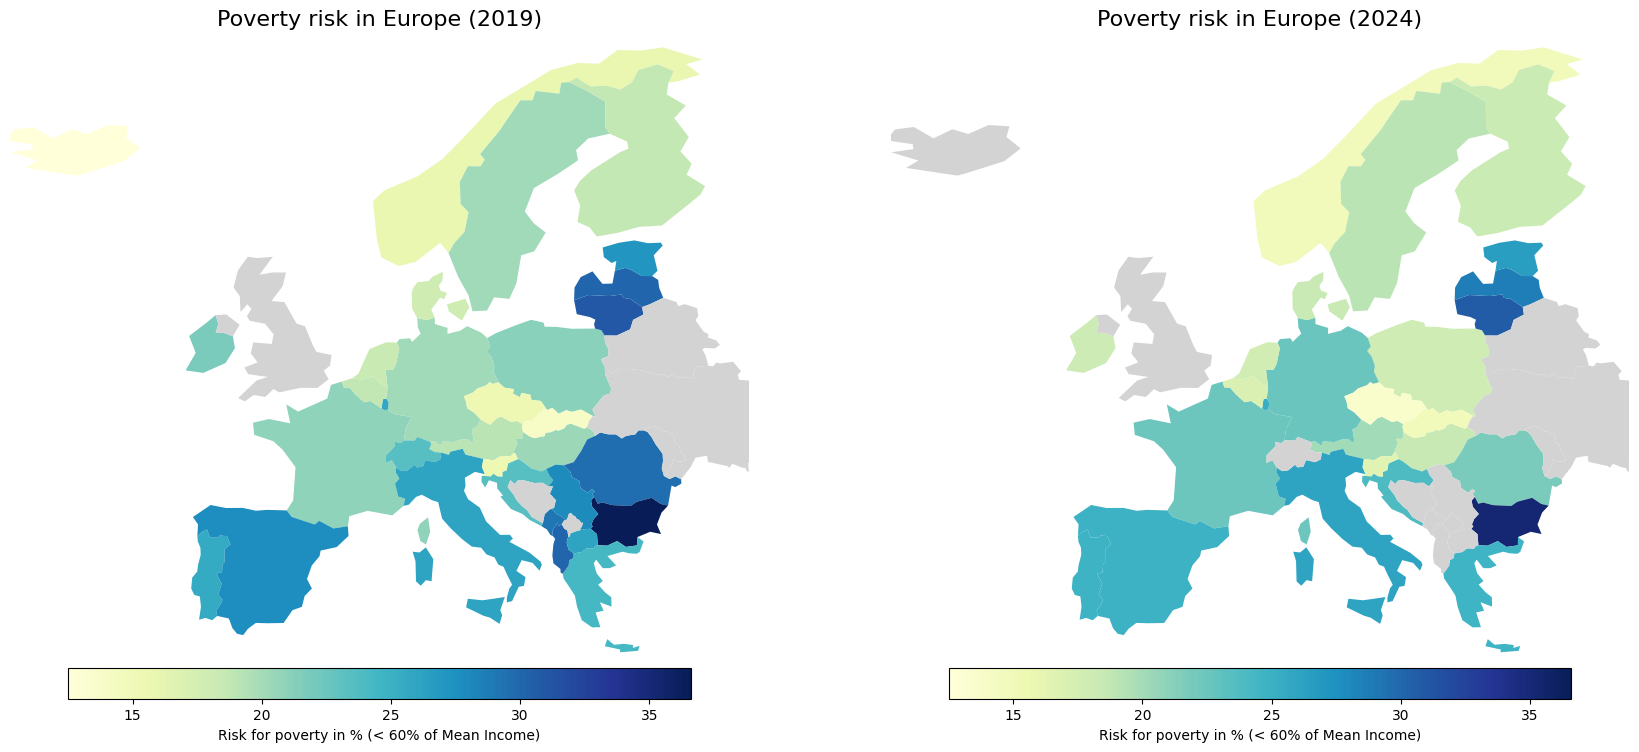

In [59]:
df_1 = get_data_for_year(df_poverty_long, 2019)
df_2 = get_data_for_year(df_poverty_long, 2024)

df_1["pov"] = df_1["pov"].astype(str).str.replace(",", ".").astype(float)
df_2["pov"] = df_2["pov"].astype(str).str.replace(",", ".").astype(float)

combined_values = pd.concat([df_1["pov"], df_2["pov"]])
vmin = combined_values.min()
vmax = combined_values.max()

# Merge with geo data
map_1 = europe.merge(df_1, left_on="ADM0_A3", right_on="iso_a3", how="left")
map_2 = europe.merge(df_2, left_on="ADM0_A3", right_on="iso_a3", how="left")

# Plot both maps
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for ax, map_df, year in zip(axes, [map_1, map_2], [2019, 2024]):
    map_df.plot(
        column="pov",
        ax=ax,
        cmap="YlGnBu",
        vmin=vmin,
        vmax=vmax,
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "No data"},
        legend_kwds={
            "label": "Risk for poverty in % (< 60% of Mean Income)",
            "orientation": "horizontal",
            "shrink": 0.7,
            "pad": 0,
            "aspect": 20
        }
    )
    ax.set_xlim(-24, 35)
    ax.set_ylim(34, 72)
    ax.set_title(f"Poverty risk in Europe ({year})", fontsize=16)
    ax.axis("off")

plt.tight_layout()

plt.savefig("pov_2019_2024.png", dpi=300, bbox_inches="tight")
plt.show()

This scatter plot shows the relationship between poverty rate and the Gini index (inequality) across European countries in 2024.

- Each point represents a country, comparing the share of people below 60% of mean income to overall income inequality.
- The trend line and narrow confidence band reflect the tight linear relationship between these two measures.

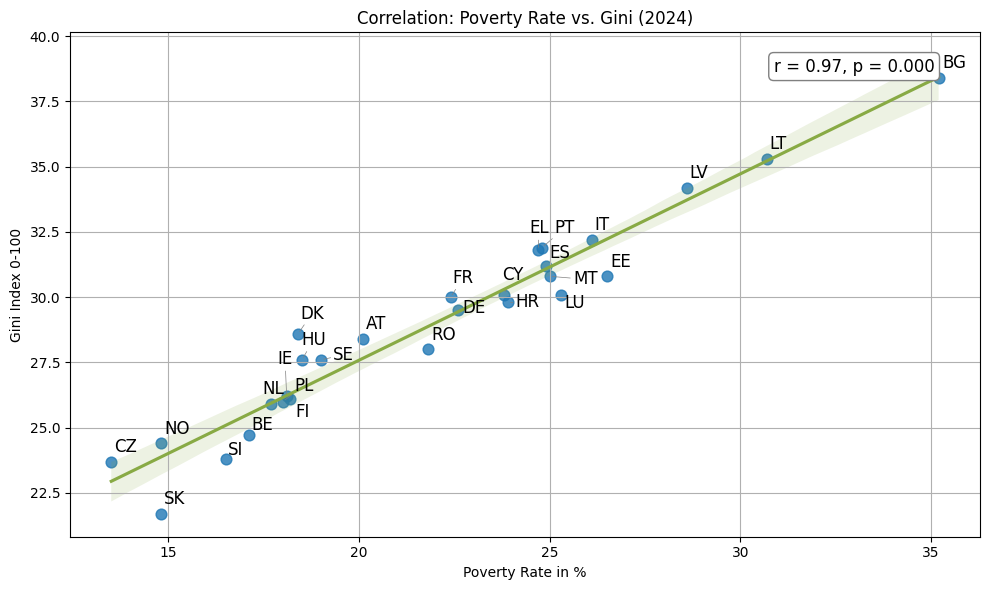

In [62]:
df_income_1 = merge_poverty_and_gini(get_data_for_year(df_poverty_long, 2024), get_data_for_year(df_gini_long, 2024))
df_income_1 = df_income_1.dropna()

r, p_value = pearsonr(df_income_1["pov"], df_income_1["gini"])
corr_label = f"r = {r:.2f}, p = {p_value:.3f}"

plt.figure(figsize=(10, 6))
sns.regplot(data=df_income_1, x="pov", y="gini", scatter_kws={"s": 60}, line_kws={"color": "#8a4"})

texts = []
for i, row in df_income_1.iterrows():
    texts.append(plt.text(row["pov"], row["gini"], row["geo"], fontsize=12, ha="left", va="bottom"))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.text(
    0.95, 0.95, corr_label,
    transform=plt.gca().transAxes,
    fontsize=12,
    ha='right', va='top',
    bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.3')
)
plt.title(f"Correlation: Poverty Rate vs. Gini ({year})")
plt.xlabel("Poverty Rate in %")
plt.ylabel("Gini Index 0-100")
plt.grid(True)
plt.tight_layout()

plt.savefig("corr_pov_gini_2024.png", dpi=300, bbox_inches="tight")
plt.show()

This scatter plot shows the relationship between poverty rate and the Gini index across all European countries from 2015 to 2024.

- Each point represents a country-year observation, comparing the share of people at risk of poverty to overall income inequality.
- The trend line illustrates a stable and significant association across the decade.

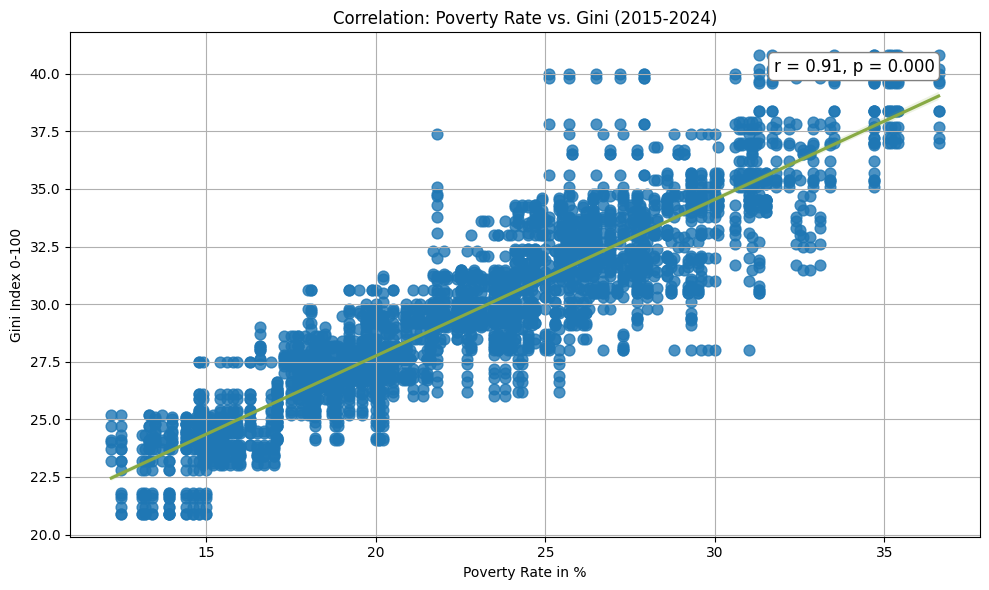

In [63]:
df_income_1 = merge_poverty_and_gini(get_data_for_years(df_poverty_long, 2015,2024), get_data_for_years(df_gini_long, 2015,2024))
df_income_1 = df_income_1.dropna()

r, p_value = pearsonr(df_income_1["pov"], df_income_1["gini"])
corr_label = f"r = {r:.2f}, p = {p_value:.3f}"

plt.figure(figsize=(10, 6))
sns.regplot(data=df_income_1, x="pov", y="gini", scatter_kws={"s": 60}, line_kws={"color": "#8a4"})

plt.text(
    0.95, 0.95, corr_label,
    transform=plt.gca().transAxes,
    fontsize=12,
    ha='right', va='top',
    bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.3')
)
plt.title(f"Correlation: Poverty Rate vs. Gini (2015-{year})")
plt.xlabel("Poverty Rate in %")
plt.ylabel("Gini Index 0-100")
plt.grid(True)
plt.tight_layout()

plt.savefig("corr_pov_gini_2015_2024.png", dpi=300, bbox_inches="tight")
plt.show()

### 8.7 Plot of GINI Map in Europe

This map shows the Gini Index, a measure of income inequality, across European countries in 2019 and 2024.

- Higher Gini values (darker shades) indicate greater income inequality; lower values (lighter shades) reflect more equal income distribution.
- Grey areas represent missing or unavailable data.
- The side-by-side view illustrates how inequality levels have changed over time across the region.


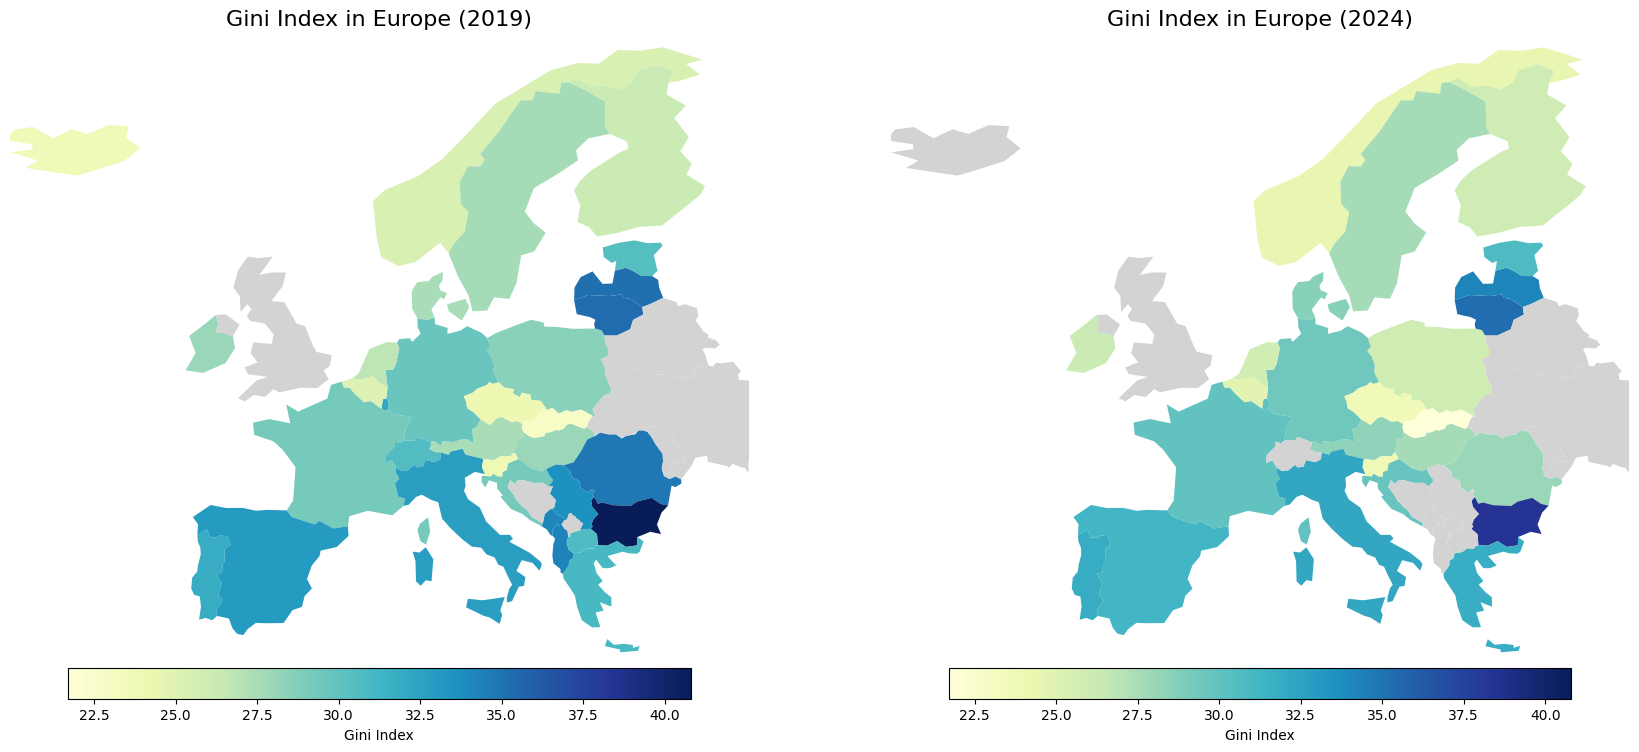

In [64]:
df_1 = get_data_for_year(df_gini_long, 2019)
df_2 = get_data_for_year(df_gini_long, 2024)

df_1["gini"] = df_1["gini"].astype(str).str.replace(",", ".").astype(float)
df_2["gini"] = df_2["gini"].astype(str).str.replace(",", ".").astype(float)

combined_values = pd.concat([df_1["gini"], df_2["gini"]])
vmin = combined_values.min()
vmax = combined_values.max()

# Merge with geo data
map_1 = europe.merge(df_1, left_on="ADM0_A3", right_on="iso_a3", how="left")
map_2 = europe.merge(df_2, left_on="ADM0_A3", right_on="iso_a3", how="left")

# Plot both maps
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for ax, map_df, year in zip(axes, [map_1, map_2], [2019, 2024]):
    map_df.plot(
        column="gini",
        ax=ax,
        cmap="YlGnBu",
        vmin=vmin,
        vmax=vmax,
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "No data"},
        legend_kwds={
            "label": "Gini Index",
            "orientation": "horizontal",
            "shrink": 0.7,
            "pad": 0,
            "aspect": 20
        }
    )
    ax.set_xlim(-24, 35)
    ax.set_ylim(34, 72)
    ax.set_title(f"Gini Index in Europe ({year})", fontsize=16)
    ax.axis("off")

plt.tight_layout()

plt.savefig("gini_2019_2024.png", dpi=300, bbox_inches="tight")
plt.show()

### 8.8 Heatmap plots

This heatmap shows the poverty risk (%) across European countries for the years 2009, 2014, 2019, and 2024.

- Each cell represents the share of the population earning below 60% of the national mean income in a given year.
- Darker shades indicate higher poverty risk; lighter shades indicate lower risk.
- The chart enables comparison of poverty trends over time and across countries, highlighting both persistent and shifting vulnerabilities.

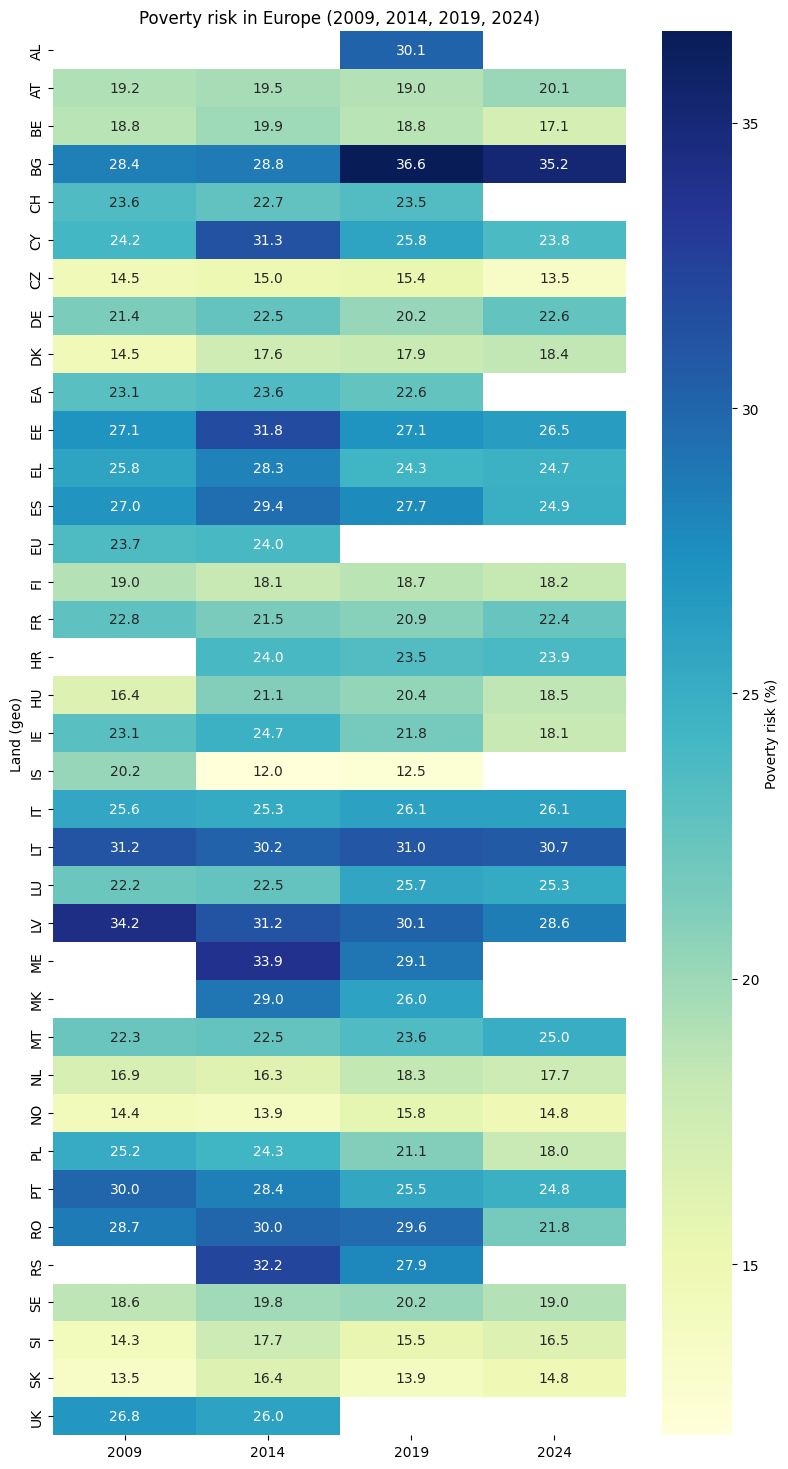

In [65]:
selected_year = 2009, 2014, 2019, 2024
df_year = df_poverty_long[df_poverty_long["year"].isin(selected_year)]
heatmap_data = df_year.pivot(index="geo", columns="year", values="pov")
heatmap_data = heatmap_data.dropna(how="all")

plt.figure(figsize=(8, len(heatmap_data) * 0.4))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={"label": "Poverty risk (%)"})

plt.title(f"Poverty risk in Europe {selected_year}")
plt.ylabel("Land (geo)")
plt.xlabel("")
plt.tight_layout()
plt.savefig("heatmap_pov_2009_2024.png", dpi=300, bbox_inches="tight")
plt.show()


This heatmap shows the Gini Index (0–100 scale) across European countries for the years 2009, 2014, 2019, and 2024.

- Each cell represents the level of income inequality in a country during a specific year.
- Darker shades indicate higher inequality, while lighter shades represent more equal income distributions.
- The chart reveals both persistent patterns and shifting trends in inequality over time across Europe.


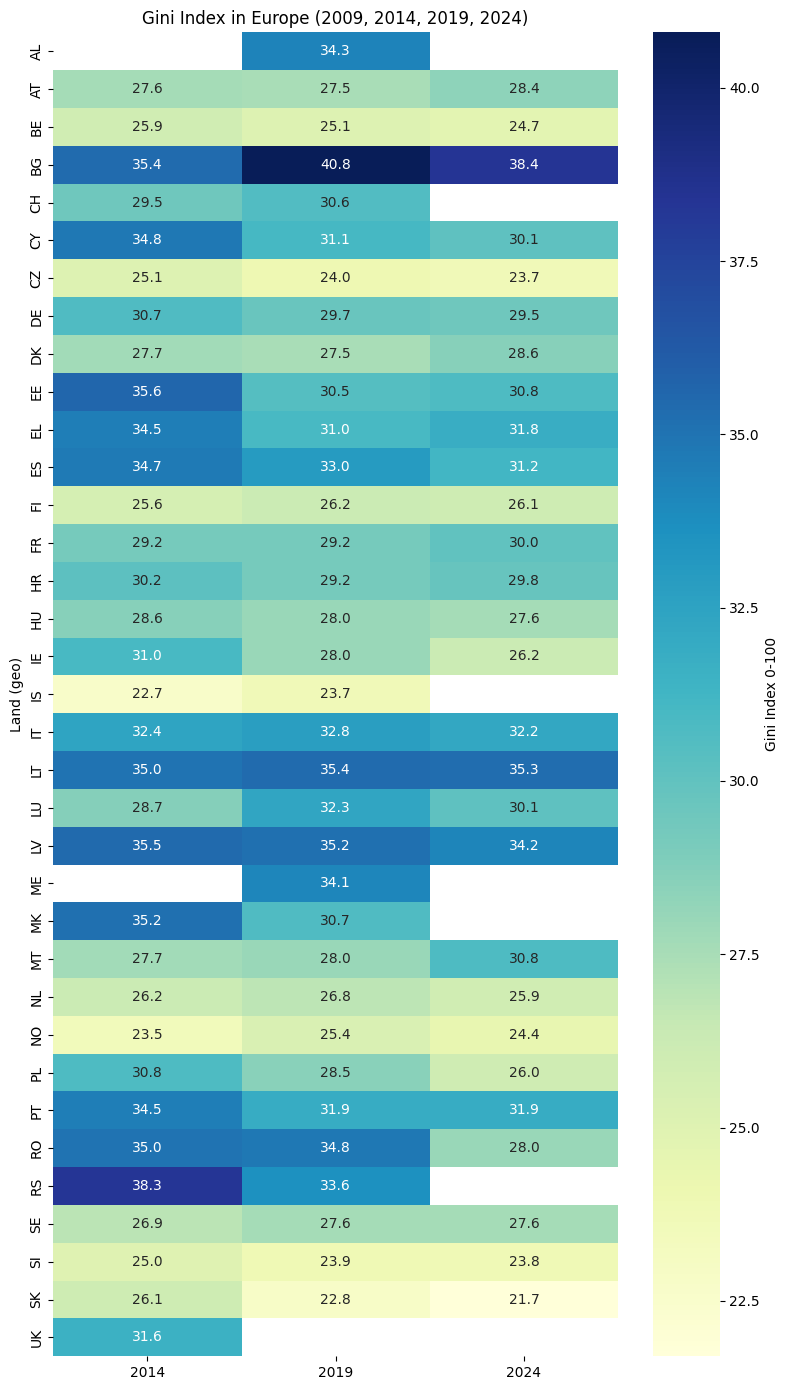

In [66]:
selected_year = 2009, 2014, 2019, 2024
df_year = df_gini_long[df_gini_long["year"].isin(selected_year)]
heatmap_data = df_year.pivot(index="geo", columns="year", values="gini")
heatmap_data = heatmap_data.dropna(how="all")

plt.figure(figsize=(8, len(heatmap_data) * 0.4))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={"label": "Gini Index 0-100"})

plt.title(f"Gini Index in Europe {selected_year}")
plt.ylabel("Land (geo)")
plt.xlabel("")
plt.tight_layout()

plt.savefig("heatmap_gini_2009_2024.png", dpi=300, bbox_inches="tight")
plt.show()

This heatmap shows household living costs as a percentage of income across European countries for the years 2009, 2014, 2019, and 2024.

- Each cell represents the proportion of income spent on housing and utility costs in a given year.
- Darker shades indicate higher cost burdens; lighter shades reflect more affordable living conditions.
- The visualization reveals country-level differences and trends in housing cost pressure over time.


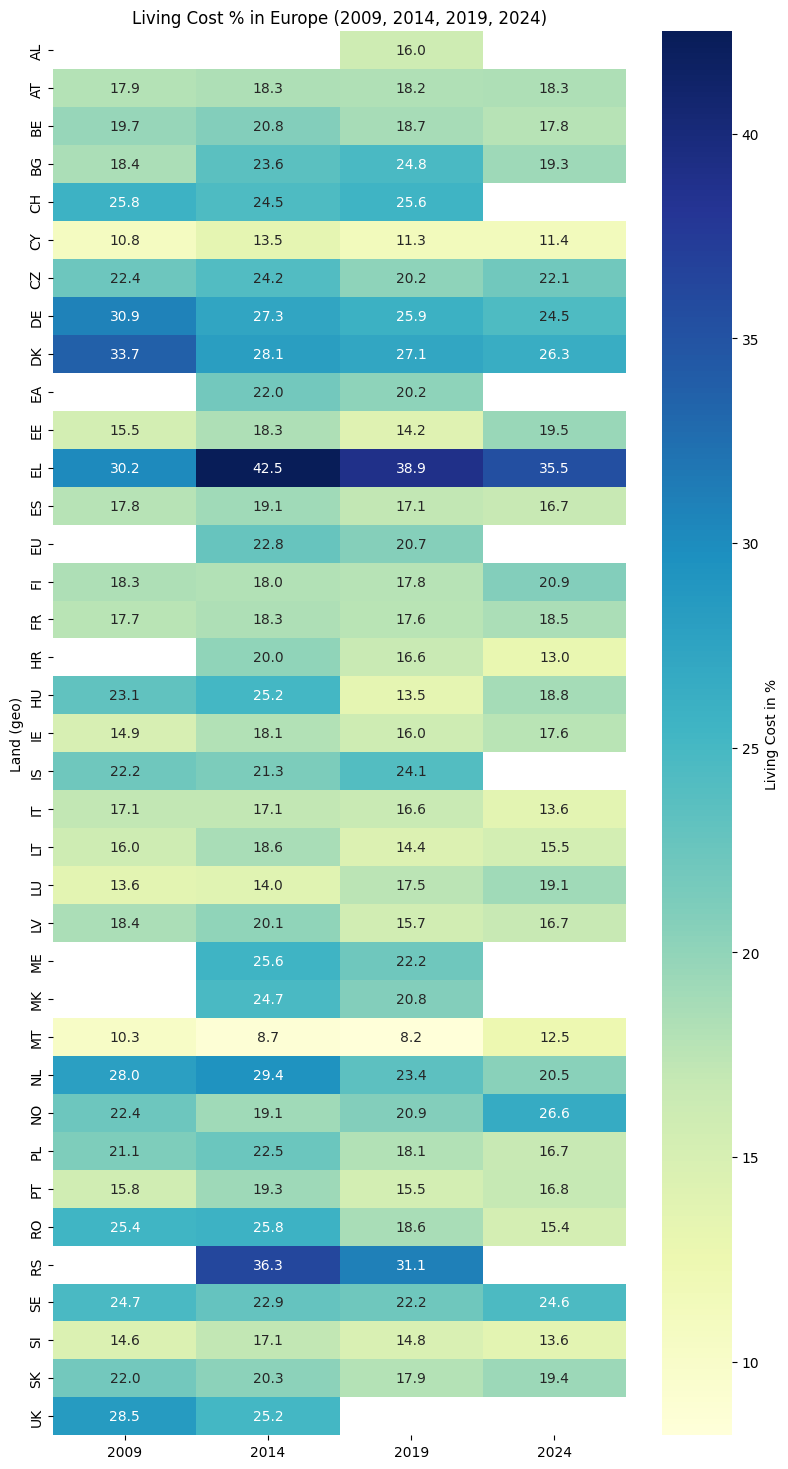

In [67]:
selected_year = 2009, 2014, 2019, 2024
df_year = df_costs_long[df_costs_long["year"].isin(selected_year)]
heatmap_data = df_year.pivot(index="geo", columns="year", values="cost_share")
heatmap_data = heatmap_data.dropna(how="all")

plt.figure(figsize=(8, len(heatmap_data) * 0.4))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={"label": "Living Cost in %"})

plt.title(f"Living Cost % in Europe {selected_year}")
plt.ylabel("Land (geo)")
plt.xlabel("")
plt.tight_layout()

plt.savefig("heatmap_costs_2009_2024.png", dpi=300, bbox_inches="tight")
plt.show()


## Conclusion

This study set out to explore how economic inequality contributes to the emergence of opinion polarization in European societies. By integrating real-world socioeconomic data with a modified Deffuant agent-based model, we simulated how frustration—defined as a function of income disparity—shapes individuals' willingness to engage with differing viewpoints.

**Key findings include:**

- Countries with higher income inequality (as measured by the Gini coefficient and at-risk-of-poverty rates) tend to exhibit greater polarization in simulated opinion dynamics.
- Agent-level frustration significantly increases the likelihood of extreme opinions and slows convergence toward centrist values.
- When frustration is removed from the model, polarization levels drop substantially, even in unequal societies, highlighting its amplifying role.
- Countries cluster into distinct polarization profiles, potentially corresponding to underlying economic structures and redistribution policies.

These insights reinforce the growing consensus in political science and behavioral economics that inequality is not only a material condition but also a psychosocial catalyst for societal division. Our model provides a simplified but useful framework for understanding how socioeconomic forces shape social cohesion and fragmentation over time.